In [3]:
!pip install numpy matplotlib
!pip install fenics
!pip install scipy
!docker run -ti -v $PWD:/home/fenics/shared -w /home/fenics/shared quay.io/fenicsproject/stable:current


/bin/bash: line 1: docker: command not found


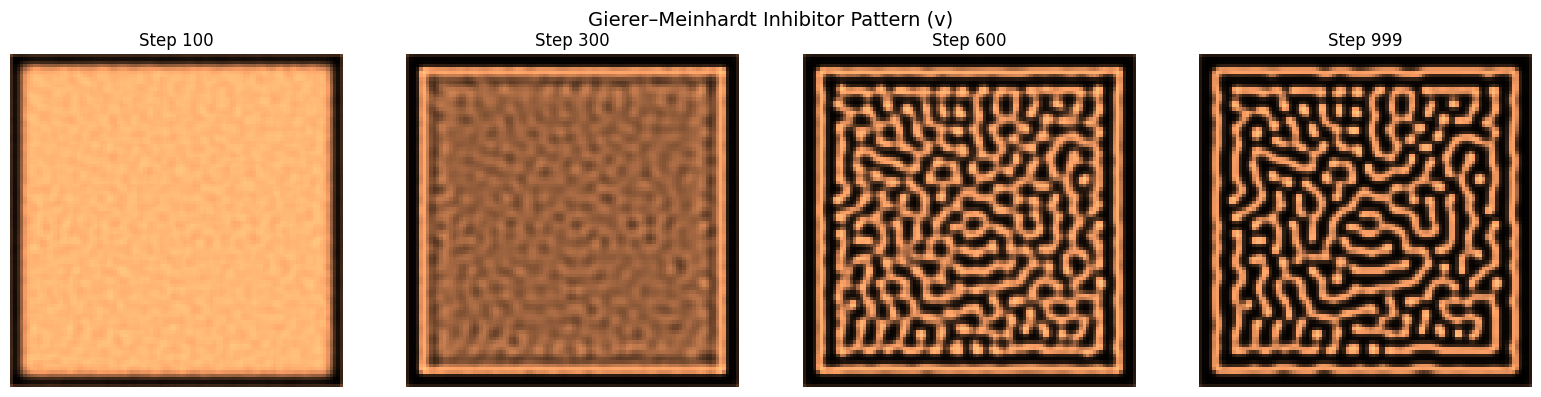

<Figure size 640x480 with 0 Axes>

In [4]:
import numpy as np
import matplotlib.pyplot as plt


size = 100
dx = 1.0
dt = 0.1
n = 1000
Du = 2.0
Dv = 0.1
rho = 0.5
kappa = 0.23
mu = 1.0
ku = 0.9
movieOutput = False
frameMod = 100


def laplacian_operator(U, V, dx):
    Lu = (U[0:-2,1:-1] + U[1:-1,0:-2] + U[1:-1,2:] + U[2:,1:-1] - 4 * U[1:-1,1:-1]) / dx**2
    Lv = (V[0:-2,1:-1] + V[1:-1,0:-2] + V[1:-1,2:] + V[2:,1:-1] - 4 * V[1:-1,1:-1]) / dx**2
    return Lu, Lv

U = 1 + 0.05 * np.random.rand(size + 2, size + 2)
V = 1 + 0.05 * np.random.rand(size + 2, size + 2)

snapshots = []

for i in range(n):
    u = U[1:-1, 1:-1]
    v = V[1:-1, 1:-1]

    Lu, Lv = laplacian_operator(U, V, dx)
    vv = v**2
    sv = rho * (vv / (u * (1 + kappa * vv)) - mu * v) + Dv * Lv
    su = rho * (vv - ku * u) + Du * Lu

    u += dt * su
    v += dt * sv

    U[1:-1, 1:-1] = u
    V[1:-1, 1:-1] = v

    if i in [100, 300, 600, 999]:
        snapshots.append(v.copy())

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for j, snap in enumerate(snapshots):
    axs[j].imshow(snap, cmap='copper', origin='lower', extent=[0, size, 0, size])
    axs[j].set_title(f"Step { [100, 300, 600, 999][j] }")
    axs[j].axis('off')
plt.suptitle("Gierer–Meinhardt Inhibitor Pattern (v)", fontsize=14)
plt.tight_layout()
plt.show()
plt.savefig("inhibitor_pattern.png")

In [5]:
!pip install meshpy


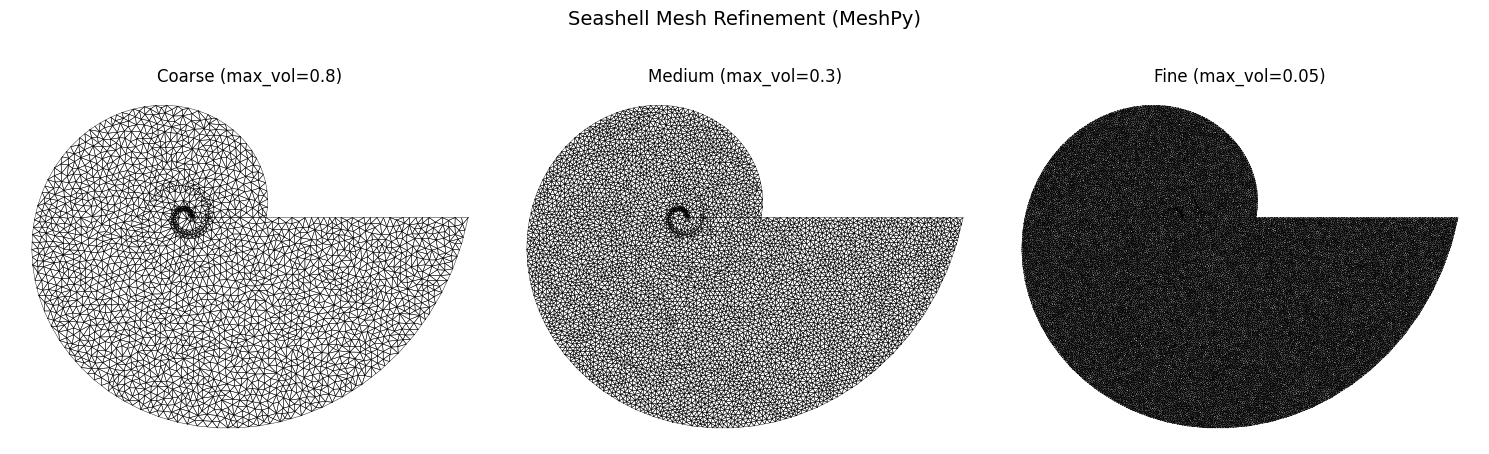

<Figure size 640x480 with 0 Axes>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from meshpy.triangle import MeshInfo, build

def generate_seashell_boundary(num_points=200, a=1.0, b=0.2, revolutions=3):
    thetas = np.linspace(0, 2 * np.pi * revolutions, num_points)
    r = a * np.exp(b * thetas)
    x = r * np.cos(thetas)
    y = r * np.sin(thetas)
    return list(zip(x, y))

def generate_seashell_mesh(points, max_vol):
    mesh_info = MeshInfo()
    mesh_info.set_points(points)
    facets = [(i, (i + 1) % len(points)) for i in range(len(points))]
    mesh_info.set_facets(facets)
    return build(mesh_info, max_volume=max_vol)

def plot_mesh(ax, mesh, title):
    for tri in mesh.elements:
        pts = [mesh.points[i] for i in tri] + [mesh.points[tri[0]]]
        x, y = zip(*pts)
        ax.plot(x, y, 'k-', lw=0.3)
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.axis('off')

resolutions = [0.8, 0.3, 0.05]
labels = ["Coarse", "Medium", "Fine"]

boundary_points = generate_seashell_boundary()
meshes = [generate_seashell_mesh(boundary_points, max_vol) for max_vol in resolutions]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax, mesh, label in zip(axs, meshes, labels):
    plot_mesh(ax, mesh, f"{label} (max_vol={resolutions[labels.index(label)]})")

plt.suptitle("Seashell Mesh Refinement (MeshPy)", fontsize=14)
plt.tight_layout()
plt.show()
plt.savefig("seashell_mesh.png")

In [1]:
import numpy as np
from scipy.sparse import lil_matrix

def assemble_fem_matrices(points, triangles):
    from scipy.sparse import lil_matrix

    n_points = len(points)
    M = lil_matrix((n_points, n_points))
    K = lil_matrix((n_points, n_points))

    for tri in triangles:
        i, j, k = tri
        p0 = np.array(points[i])
        p1 = np.array(points[j])
        p2 = np.array(points[k])


        mat_T = np.array([[p1[0] - p0[0], p2[0] - p0[0]],
                          [p1[1] - p0[1], p2[1] - p0[1]]])
        area = 0.5 * abs(np.linalg.det(mat_T))


        b = np.array([p1 - p0, p2 - p0])
        J = b.T
        inv_J = np.linalg.inv(J)


        grad_phi_ref = np.array([[-1, -1], [1, 0], [0, 1]])
        grad_phi_phys = grad_phi_ref @ inv_J.T


        for a in range(3):
            for b in range(3):
                K[tri[a], tri[b]] += area * np.dot(grad_phi_phys[a], grad_phi_phys[b])


        for a in range(3):
            for b in range(3):
                M[tri[a], tri[b]] += area / 12 if a != b else area / 6

    return M.tocsr(), K.tocsr()


[Step 200] u: min=5.025e-01, max=5.280e-01, contains nan=False
[Step 200] v: min=6.828e-01, max=7.852e-01, contains nan=False
[Step 400] u: min=6.004e-01, max=7.100e-01, contains nan=False
[Step 400] v: min=4.205e-01, max=8.782e-01, contains nan=False
[Step 600] u: min=4.846e-01, max=9.122e-01, contains nan=False
[Step 600] v: min=4.847e-02, max=1.374e+00, contains nan=False


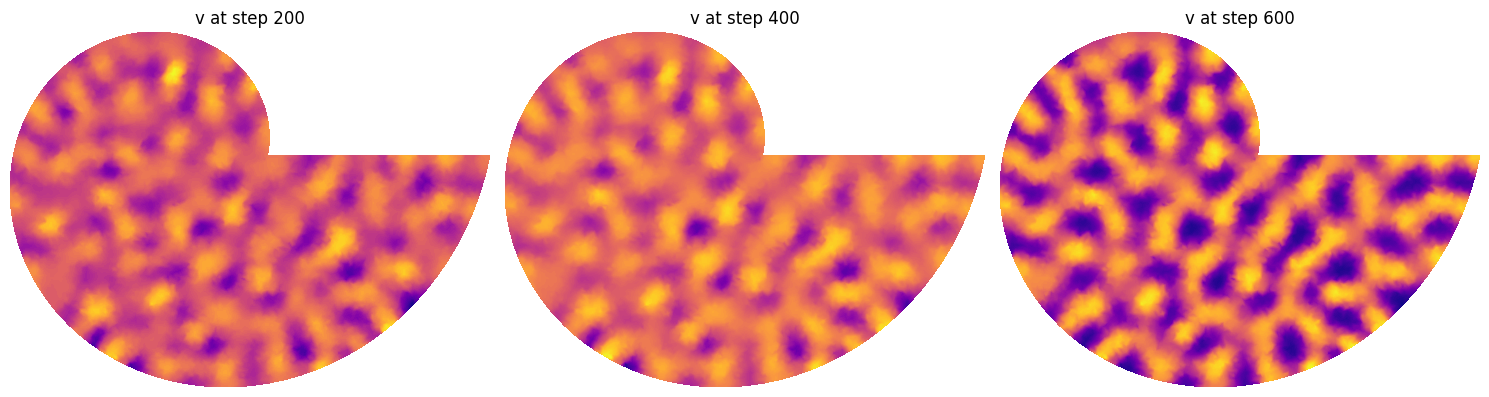

<Figure size 640x480 with 0 Axes>

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from meshpy.triangle import MeshInfo, build
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve

def generate_seashell_boundary(num_points=300, a=1.0, b=0.2, revolutions=3):
    theta = np.linspace(0, 2 * np.pi * revolutions, num_points)
    r = a * np.exp(b * theta)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return list(zip(x, y))

def generate_mesh(points, max_vol=0.2):
    mesh_info = MeshInfo()
    mesh_info.set_points(points)
    mesh_info.set_facets([(i, (i + 1) % len(points)) for i in range(len(points))])
    return build(mesh_info, max_volume=max_vol)

def assemble_fem_matrices(points, triangles):
    n = len(points)
    M = lil_matrix((n, n))
    K = lil_matrix((n, n))

    for tri in triangles:
        i, j, k = tri
        p0, p1, p2 = np.array(points[i]), np.array(points[j]), np.array(points[k])
        mat_T = np.array([[p1[0] - p0[0], p2[0] - p0[0]], [p1[1] - p0[1], p2[1] - p0[1]]])
        area = 0.5 * abs(np.linalg.det(mat_T))

        inv_J = np.linalg.inv(mat_T)
        grad_phi_ref = np.array([[-1, -1], [1, 0], [0, 1]])
        grad_phi_phys = grad_phi_ref @ inv_J.T

        for a in range(3):
            for b in range(3):
                K[tri[a], tri[b]] += area * np.dot(grad_phi_phys[a], grad_phi_phys[b])
                M[tri[a], tri[b]] += area / 12 if a != b else area / 6

    return M.tocsr(), K.tocsr()

def fem_gierer_meinhardt_step(u, v, M, K, Du, Dv, rho, ku, kappa, mu, dt):
    u = np.clip(u, 1e-6, 1e3)
    v = np.clip(v, 1e-6, 1e3)

    vu2 = v**2
    f_u = rho * (vu2 - ku * u)
    f_v = rho * (vu2 / (u * (1 + kappa * vu2) + 1e-6) - mu * v)

    A_u = M + dt * Du * K
    A_v = M + dt * Dv * K
    b_u = M @ u + dt * M @ f_u
    b_v = M @ v + dt * M @ f_v

    u_new = spsolve(A_u, b_u)
    v_new = spsolve(A_v, b_v)

    assert np.all(np.isfinite(u_new)), "Non-finite u_new"
    assert np.all(np.isfinite(v_new)), "Non-finite v_new"
    return u_new, v_new

boundary = generate_seashell_boundary()
mesh = generate_mesh(boundary, max_vol=0.2)
points = mesh.points
triangles = mesh.elements
M, K = assemble_fem_matrices(points, triangles)

Du, Dv = 2.0, 0.1
rho, ku, kappa, mu = 0.5, 0.9, 0.238, 1.0
dt = 0.1
num_steps = 600
n = len(points)
u = 1 + 0.05 * np.random.rand(n)
v = 1 + 0.05 * np.random.rand(n)

snapshots = {}
for step in range(1, num_steps + 1):
    u, v = fem_gierer_meinhardt_step(u, v, M, K, Du, Dv, rho, ku, kappa, mu, dt)

    if step in [200, 400, 600]:
        print(f"[Step {step}] u: min={u.min():.3e}, max={u.max():.3e}, contains nan={np.isnan(u).any()}")
        print(f"[Step {step}] v: min={v.min():.3e}, max={v.max():.3e}, contains nan={np.isnan(v).any()}")
        snapshots[step] = v.copy()

triang = tri.Triangulation([p[0] for p in points], [p[1] for p in points], triangles)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, step in enumerate([200, 400, 600]):
    z = snapshots[step]
    axs[i].tricontourf(triang, z, levels=100, cmap='plasma')
    axs[i].set_title(f"v at step {step}")
    axs[i].axis('off')
    axs[i].set_aspect('equal')

plt.tight_layout()
plt.show()
plt.savefig("inhibitor_pattern2.png")


In [9]:
!pip install torch torchvision torchaudio

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

true_Du = 0.01
true_Dv = 0.02
true_rho = 1.0
true_ku = 1.0
true_kappa = 0.2
true_mu = 1.0


def true_u(x, y, t):
    return torch.sin(np.pi * x) * torch.sin(np.pi * y) * torch.exp(-t)

def true_v(x, y, t):
    return torch.sin(np.pi * x) * torch.exp(-t)

class PINN_GM(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 2)
        )

        self.log_Du = nn.Parameter(torch.log(torch.tensor(0.1)))
        self.log_Dv = nn.Parameter(torch.log(torch.tensor(0.1)))
        self.log_rho = nn.Parameter(torch.log(torch.tensor(0.5)))
        self.log_ku = nn.Parameter(torch.log(torch.tensor(0.5)))
        self.log_kappa = nn.Parameter(torch.log(torch.tensor(0.1)))
        self.log_mu = nn.Parameter(torch.log(torch.tensor(0.5)))


    @property
    def Du(self):
        return torch.exp(self.log_Du)

    @property
    def Dv(self):
        return torch.exp(self.log_Dv)

    @property
    def rho(self):
        return torch.exp(self.log_rho)

    @property
    def ku(self):
        return torch.exp(self.log_ku)

    @property
    def kappa(self):
        return torch.exp(self.log_kappa)

    @property
    def mu(self):
        return torch.exp(self.log_mu)


    def forward(self, x, y, t):
        input = torch.cat([x, y, t], dim=1)
        return self.net(input)


def compute_residuals(model, x, y, t):
    input = torch.cat([x, y, t], dim=1).requires_grad_(True)
    output = model(x, y, t)
    u = output[:, 0:1]
    v = output[:, 1:2]

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]

    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]

    u_lap = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0] + \
            torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    v_lap = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0] + \
            torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

    eps = 1e-6
    res_u = u_t - model.Du * u_lap - model.rho * (v**2 - model.ku * u)
    res_v = v_t - model.Dv * v_lap - model.rho * ((v**2) / (u * (1 + model.kappa * v**2) + eps) - model.mu * v)

    return res_u, res_v, u, v


def compute_loss(model, x, y, t, u_data, v_data):
    res_u, res_v, u_pred, v_pred = compute_residuals(model, x, y, t)
    loss_pde = torch.mean(res_u**2) + torch.mean(res_v**2)
    loss_data = torch.mean((u_pred - u_data)**2) + torch.mean((v_pred - v_data)**2)
    return loss_pde + loss_data


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N = 1000
x = torch.rand(N, 1, device=device) * 2 - 1
y = torch.rand(N, 1, device=device) * 2 - 1
t = torch.rand(N, 1, device=device)

x_tensor = x.clone().detach().requires_grad_(True)
y_tensor = y.clone().detach().requires_grad_(True)
t_tensor = t.clone().detach().requires_grad_(True)

u_tensor = true_u(x, y, t).detach()
v_tensor = true_v(x, y, t).detach()


model = PINN_GM().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 600

for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = compute_loss(model, x_tensor, y_tensor, t_tensor, u_tensor, v_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
        print(f"  Du = {model.Du.item():.4f}  (True: {true_Du})")
        print(f"  rho = {model.rho.item():.4f}  (True: {true_rho})")
        print(f"  ku = {model.ku.item():.4f}  (True: {true_ku})")
        print()


Epoch 0, Loss: 0.357781
  Du = 0.1001  (True: 0.01)
  rho = 0.5005  (True: 1.0)
  ku = 0.5005  (True: 1.0)

Epoch 200, Loss: 0.223421
  Du = 0.0897  (True: 0.01)
  rho = 0.4177  (True: 1.0)
  ku = 0.4980  (True: 1.0)

Epoch 400, Loss: 0.166457
  Du = 0.0660  (True: 0.01)
  rho = 0.3460  (True: 1.0)
  ku = 0.5262  (True: 1.0)



[Step 200] u: min=6.788e-01, max=6.805e-01, contains nan=False
[Step 200] v: min=8.389e-01, max=8.409e-01, contains nan=False
[Step 400] u: min=7.302e-01, max=7.306e-01, contains nan=False
[Step 400] v: min=8.483e-01, max=8.485e-01, contains nan=False
[Step 600] u: min=7.275e-01, max=7.276e-01, contains nan=False
[Step 600] v: min=8.540e-01, max=8.540e-01, contains nan=False


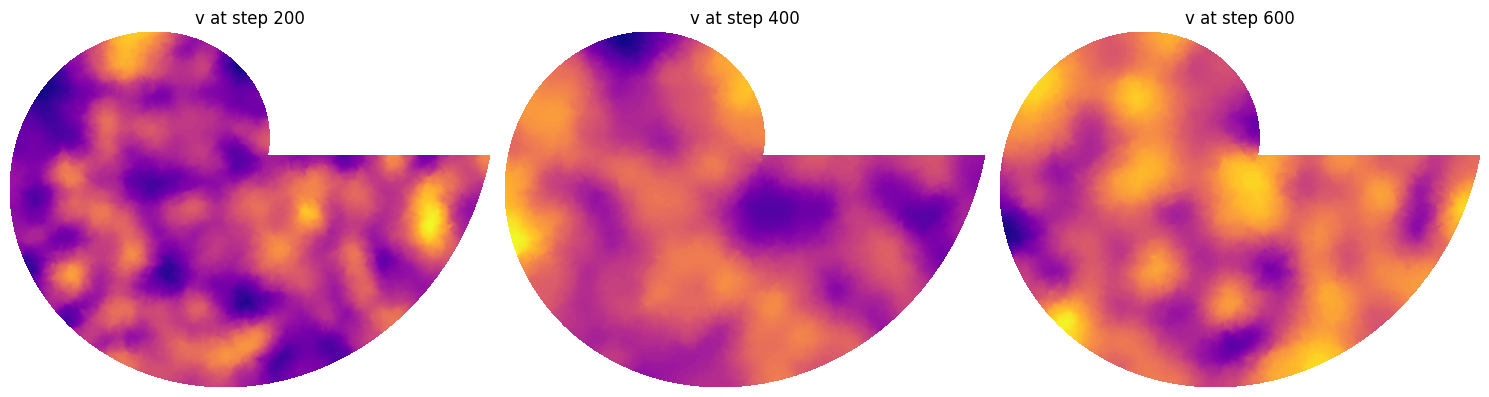

<Figure size 640x480 with 0 Axes>

In [11]:
boundary = generate_seashell_boundary()
mesh = generate_mesh(boundary, max_vol=0.2)
points = mesh.points
triangles = mesh.elements
M, K = assemble_fem_matrices(points, triangles)

Du, Dv = 0.01, 0.1
rho, ku, kappa, mu = 1.0, 1.0, 0.238, 1.0
dt = 0.1
num_steps = 600
n = len(points)
u = 1 + 0.05 * np.random.rand(n)
v = 1 + 0.05 * np.random.rand(n)

snapshots = {}
for step in range(1, num_steps + 1):
    u, v = fem_gierer_meinhardt_step(u, v, M, K, Du, Dv, rho, ku, kappa, mu, dt)

    if step in [200, 400, 600]:
        print(f"[Step {step}] u: min={u.min():.3e}, max={u.max():.3e}, contains nan={np.isnan(u).any()}")
        print(f"[Step {step}] v: min={v.min():.3e}, max={v.max():.3e}, contains nan={np.isnan(v).any()}")
        snapshots[step] = v.copy()


triang = tri.Triangulation([p[0] for p in points], [p[1] for p in points], triangles)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, step in enumerate([200, 400, 600]):
    z = snapshots[step]
    axs[i].tricontourf(triang, z, levels=100, cmap='plasma')
    axs[i].set_title(f"v at step {step}")
    axs[i].axis('off')
    axs[i].set_aspect('equal')

plt.tight_layout()
plt.show()
plt.savefig("inhibitor_pattern3.png")


[Step 200] u: min=1.314e+00, max=1.328e+00, contains nan=False
[Step 200] v: min=7.424e-01, max=7.482e-01, contains nan=False
[Step 400] u: min=1.210e+00, max=1.219e+00, contains nan=False
[Step 400] v: min=4.568e-01, max=4.594e-01, contains nan=False
[Step 600] u: min=9.664e-01, max=9.730e-01, contains nan=False
[Step 600] v: min=2.546e-01, max=2.557e-01, contains nan=False


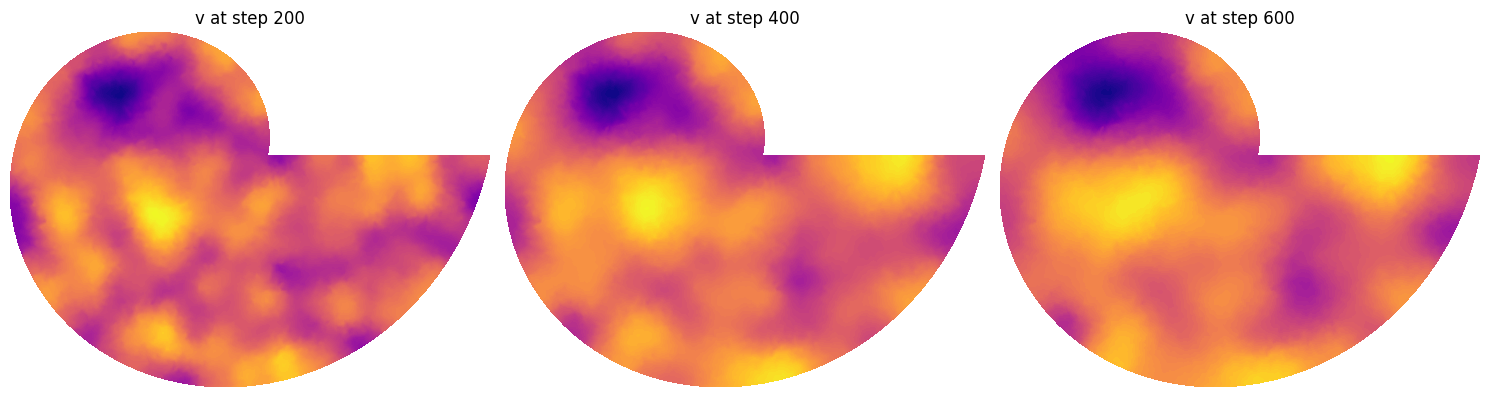

<Figure size 640x480 with 0 Axes>

In [12]:
boundary = generate_seashell_boundary()
mesh = generate_mesh(boundary, max_vol=0.2)
points = mesh.points
triangles = mesh.elements
M, K = assemble_fem_matrices(points, triangles)

Du, Dv = 0.0248, 0.1
rho, ku, kappa, mu = 0.0422, 0.3794, 0.238, 1.0
dt = 0.1
num_steps = 600
n = len(points)
u = 1 + 0.05 * np.random.rand(n)
v = 1 + 0.05 * np.random.rand(n)

snapshots = {}
for step in range(1, num_steps + 1):
    u, v = fem_gierer_meinhardt_step(u, v, M, K, Du, Dv, rho, ku, kappa, mu, dt)

    if step in [200, 400, 600]:
        print(f"[Step {step}] u: min={u.min():.3e}, max={u.max():.3e}, contains nan={np.isnan(u).any()}")
        print(f"[Step {step}] v: min={v.min():.3e}, max={v.max():.3e}, contains nan={np.isnan(v).any()}")
        snapshots[step] = v.copy()


triang = tri.Triangulation([p[0] for p in points], [p[1] for p in points], triangles)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, step in enumerate([200, 400, 600]):
    z = snapshots[step]
    axs[i].tricontourf(triang, z, levels=100, cmap='plasma')
    axs[i].set_title(f"v at step {step}")
    axs[i].axis('off')
    axs[i].set_aspect('equal')

plt.tight_layout()
plt.show()
plt.savefig("inhibitor_pattern4.png")


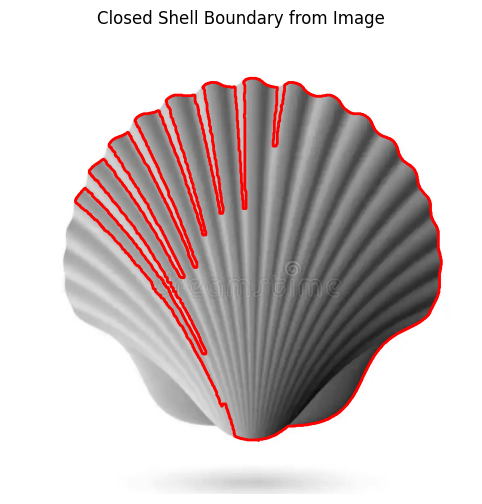

<Figure size 640x480 with 0 Axes>

In [13]:
from skimage import io, color, measure, morphology
from skimage.filters import threshold_otsu
from scipy.ndimage import binary_fill_holes
import matplotlib.pyplot as plt
import numpy as np

image = io.imread("image2.png")
if image.shape[-1] == 4:
    image = image[..., :3]  # drop alpha channel

gray_image = color.rgb2gray(image)

thresh = threshold_otsu(gray_image)
binary_mask = gray_image < thresh

binary_mask = morphology.remove_small_objects(binary_mask, min_size=500)
binary_mask = morphology.binary_closing(binary_mask, footprint=np.ones((5, 5)))
binary_mask = binary_fill_holes(binary_mask)

labeled = measure.label(binary_mask)
regions = measure.regionprops(labeled)

if not regions:
    raise ValueError("No connected regions found. Adjust thresholds or smoothing.")

largest_region = max(regions, key=lambda r: r.area)
coords = largest_region.coords

boundary_mask = np.zeros_like(binary_mask)
boundary_mask[coords[:, 0], coords[:, 1]] = 1
contour = measure.find_contours(boundary_mask, level=0.5)[0]

plt.figure(figsize=(8, 6))
plt.imshow(gray_image, cmap='gray')
plt.plot(contour[:, 1], contour[:, 0], color='red', linewidth=2)
plt.title("Closed Shell Boundary from Image")
plt.axis("off")
plt.show()
plt.savefig("shell_mask3.png")

<ipython-input-7-dc2523d819da>:14: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  closed = closing(edges, square(3))


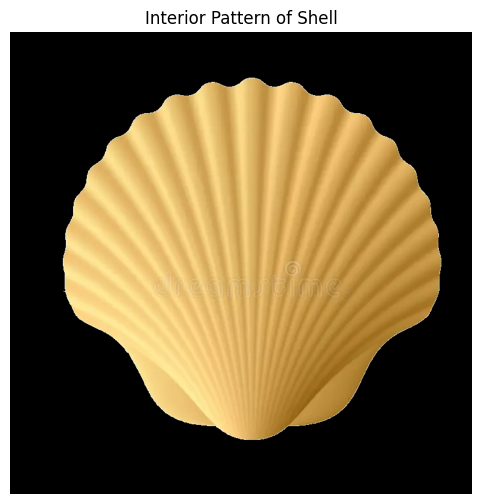

<Figure size 640x480 with 0 Axes>

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, measure, filters
from skimage.morphology import closing, square

# Step 1: Load image and convert to grayscale
img = io.imread('image2.png')  # <-- change to your actual path
img_rgb = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB) if img.shape[-1] == 4 else img
gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

# Step 2: Edge detection and thresholding
edges = cv2.Canny(gray, 50, 150)
closed = closing(edges, square(3))
contours, _ = cv2.findContours(closed.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 3: Choose the largest contour (assume it's the shell)
shell_contour = max(contours, key=cv2.contourArea)

# Step 4: Create a mask and fill the shell interior
mask = np.zeros(gray.shape, dtype=np.uint8)
cv2.fillPoly(mask, [shell_contour], 255)

# Step 5: Apply mask to original RGB image
masked_image = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

# Step 6: Display result
plt.figure(figsize=(6,6))
plt.imshow(masked_image)
plt.title("Interior Pattern of Shell")
plt.axis('off')
plt.show()
plt.savefig('shell_masked.png')

In [8]:
gray_shell = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY)
# Find nonzero pixels inside the shell (i.e., interior)
ys, xs = np.nonzero(gray_shell)
values = gray_shell[ys, xs] / 255.0  # Normalize to [0, 1]

# Normalize coordinates to [-1, 1] for PINN input
H, W = gray_shell.shape
x_norm = (xs / W) * 2 - 1
y_norm = (ys / H) * 2 - 1
t_norm = np.zeros_like(x_norm)  # assume time = 0 for static image

# Stack into tensors for PINN
x_tensor = torch.tensor(x_norm[:, None], dtype=torch.float32)
y_tensor = torch.tensor(y_norm[:, None], dtype=torch.float32)
t_tensor = torch.tensor(t_norm[:, None], dtype=torch.float32)
u_tensor = torch.tensor(values[:, None], dtype=torch.float32)

print(x_tensor)

tensor([[0.0325],
        [0.0351],
        [0.0377],
        ...,
        [0.0767],
        [0.0793],
        [0.0819]])


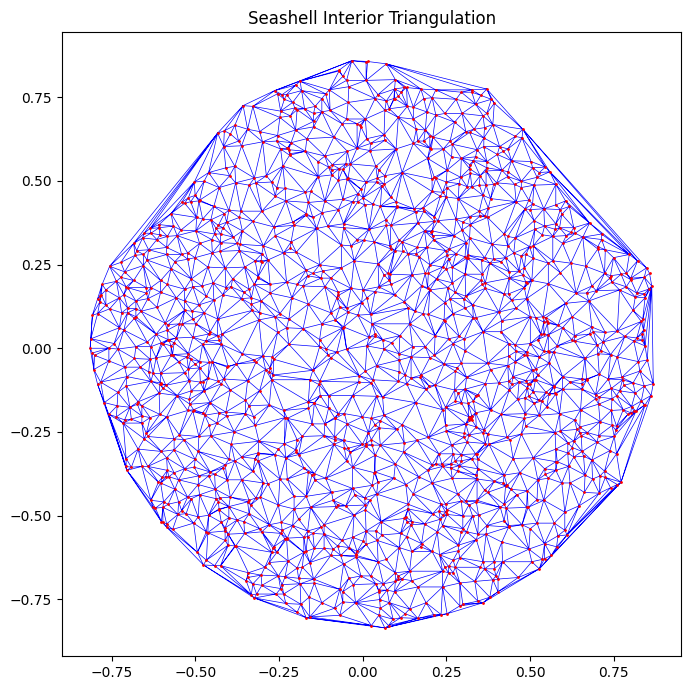

<Figure size 640x480 with 0 Axes>

In [9]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial import Delaunay

# Load the new, clean image of the shell with clear black background
img_path = "shell_mask.png"
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold the image to get binary mask
_, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

# Find contours of the white region (shell)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
shell_contour = max(contours, key=cv2.contourArea)

# Create a mask and sample points inside the shell
mask = np.zeros_like(gray)
cv2.drawContours(mask, [shell_contour], -1, 255, thickness=cv2.FILLED)

# Generate random sample points within the mask
ys, xs = np.where(mask == 255)
indices = np.random.choice(len(xs), size=1500, replace=False)
sample_points = np.vstack((xs[indices], ys[indices])).T

# Normalize points to [-1, 1] for plotting and modeling
h, w = mask.shape
normalized_points = (sample_points - np.array([[w/2, h/2]])) / np.array([[w/2, h/2]])

# Perform Delaunay triangulation on these interior points
tri = Delaunay(normalized_points)

# Plot triangulation
plt.figure(figsize=(7, 7))
plt.triplot(normalized_points[:, 0], normalized_points[:, 1], tri.simplices, color='blue', linewidth=0.5)
plt.plot(normalized_points[:, 0], normalized_points[:, 1], 'o', markersize=1, color='red')
plt.title("Seashell Interior Triangulation")
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()
plt.savefig("triangulation.png")


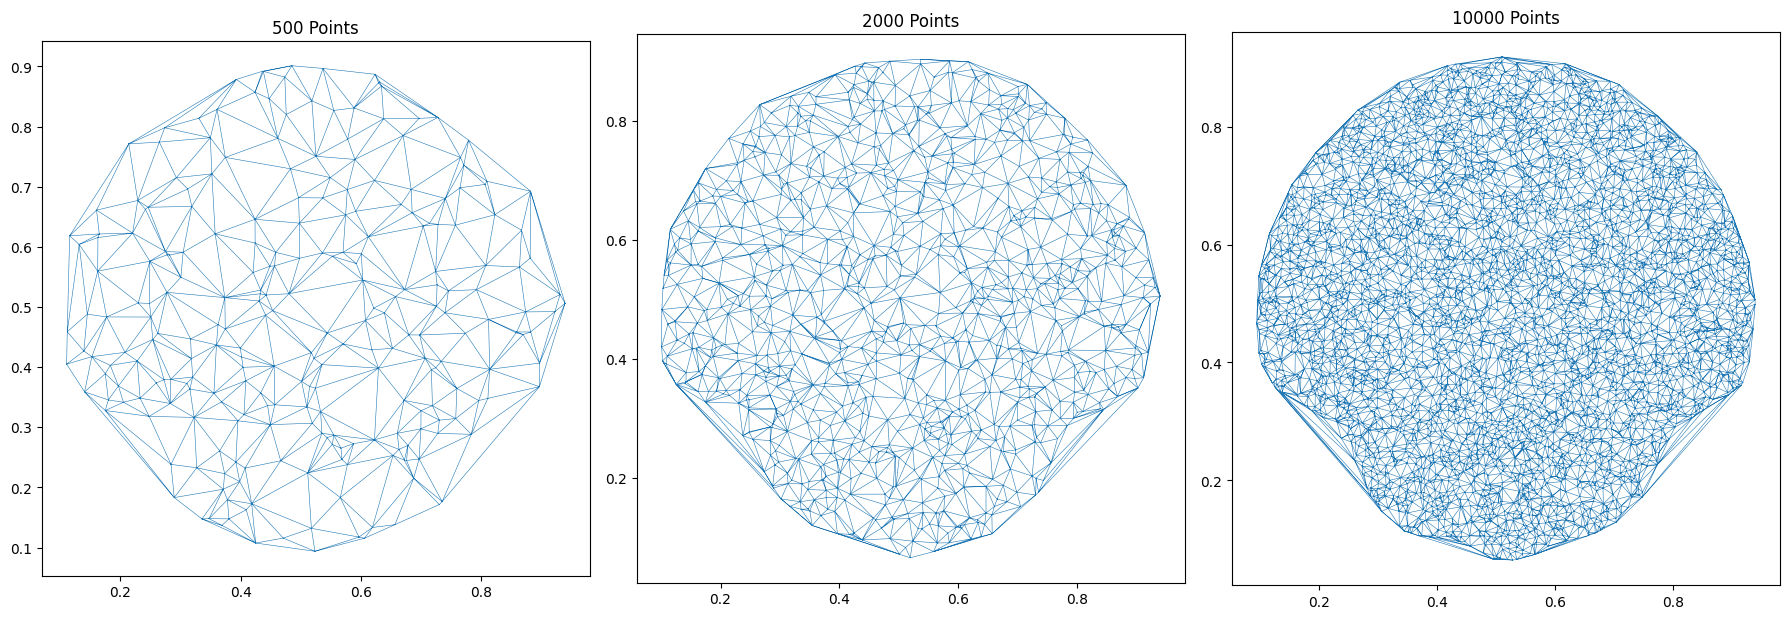

<Figure size 640x480 with 0 Axes>

In [2]:
# Re-import needed packages after kernel reset
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial import Delaunay

# Reload the uploaded shell image
image_path = 'shell_mask.png'
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold to create mask of shell
_, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
shell_mask = mask // 255  # binary mask

# Normalize dimensions
h, w = shell_mask.shape
x_min, x_max = 0.0, 1.0
y_min, y_max = 0.0, 1.0

# Plot triangulations with increasing density
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
densities = [500, 2000, 10000]

for i, num_points in enumerate(densities):
    np.random.seed(0)
    rand_pts = np.random.rand(num_points, 2)
    rand_pts[:, 0] = rand_pts[:, 0] * (x_max - x_min) + x_min
    rand_pts[:, 1] = rand_pts[:, 1] * (y_max - y_min) + y_min

    # Keep only those inside the shell mask
    indices_x = np.clip((rand_pts[:, 0] * w).astype(int), 0, w - 1)
    indices_y = np.clip(((1 - rand_pts[:, 1]) * h).astype(int), 0, h - 1)
    inside_mask = shell_mask[indices_y, indices_x] > 0
    mask_pts = rand_pts[inside_mask]

    # Triangulate
    tri = Delaunay(mask_pts)
    axs[i].triplot(mask_pts[:, 0], mask_pts[:, 1], tri.simplices, linewidth=0.4)
    axs[i].set_aspect('equal')
    axs[i].set_title(f'{num_points} Points')

plt.tight_layout()
plt.show()
plt.savefig("triangulations2.png")

Step 0: u.min = 0.9503, u.max = 1.0499


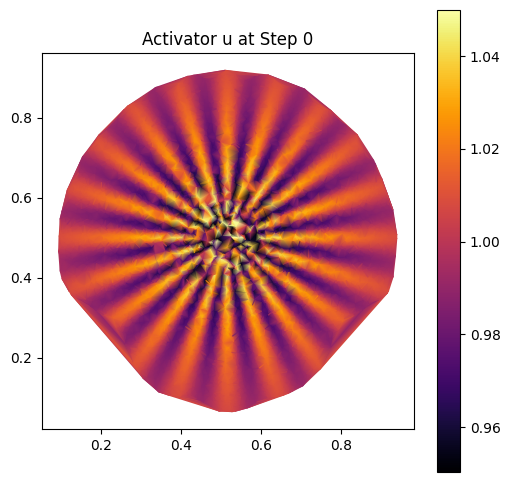

Step 200: u.min = 66.6414, u.max = 66.6415


<Figure size 640x480 with 0 Axes>

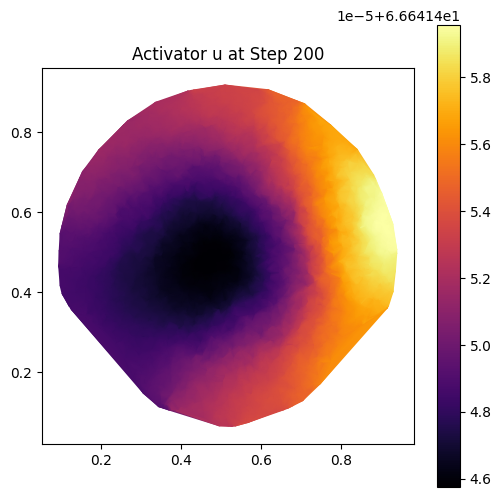

Step 400: u.min = 38.9343, u.max = 38.9343


<Figure size 640x480 with 0 Axes>

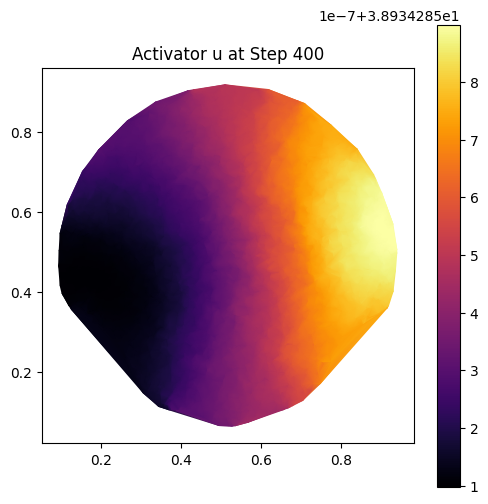

Step 600: u.min = 19.4788, u.max = 19.4788


<Figure size 640x480 with 0 Axes>

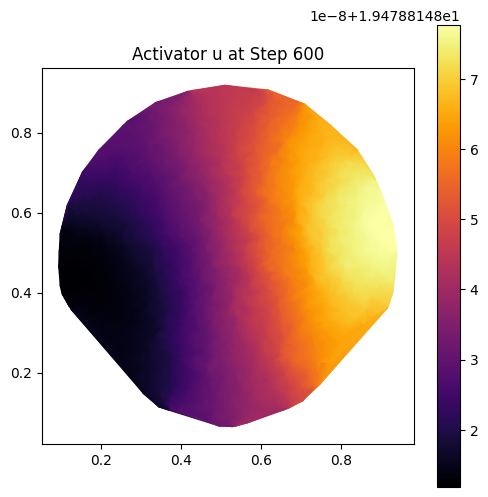

Step 800: u.min = 15.5494, u.max = 15.5494


<Figure size 640x480 with 0 Axes>

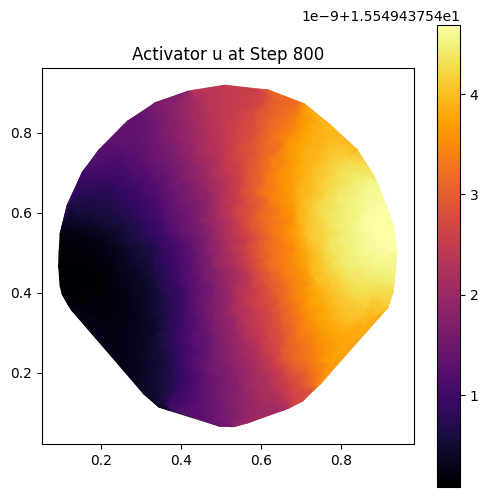

Step 1000: u.min = 22.9820, u.max = 22.9820


<Figure size 640x480 with 0 Axes>

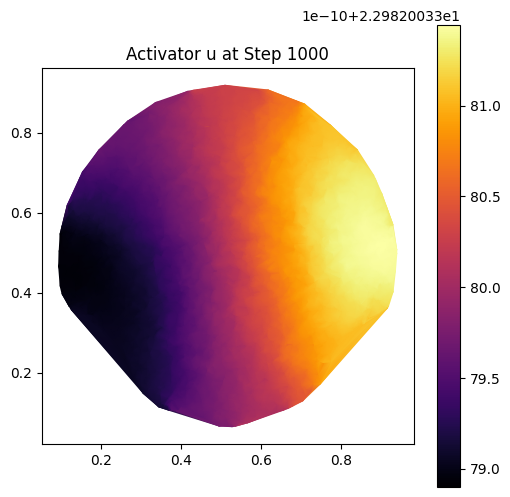

<Figure size 640x480 with 0 Axes>

In [18]:

Du     = 0.001    # activator diffusion
Dv     = 0.02     # inhibitor diffusion
rho    = 1.0      # base reaction rate
ku     = 0.08     # decay of activator
kappa  = 0.1      # nonlinearity saturation
mu     = 0.05     # decay of inhibitor
dt     = 0.1
T      = 3000     # longer to see shell-like patterns



points = mask_pts  # from your earlier code
triangles = tri.simplices

M, K = assemble_fem_matrices(points, triangles)


def initialize_shell_pattern(points):
    u0, v0 = 1.0, 1.0
    u = np.full(len(points), u0)
    v = np.full(len(points), v0)


    pts = np.array(points)
    center = pts.mean(axis=0)

    for i, (x, y) in enumerate(points):
        dx, dy = x - center[0], y - center[1]
        r = np.sqrt(dx**2 + dy**2)
        angle = np.arctan2(dy, dx)


        radial_profile = np.exp(-10 * r**2)  # sharper sink in center
        angular_mod = np.cos(20 * angle)     # 20 radial grooves

        u[i] += 0.05 * angular_mod * radial_profile
        v[i] += 0.05 * angular_mod * radial_profile

    return u, v


u, v = initialize_shell_pattern(points)


T = 1000         # total number of time steps
dt = 0.1         # time step size
plot_interval = 200  # how often to plot

for t in range(T + 1):
    if t % plot_interval == 0:
        # Plot current activator pattern
        print(f"Step {t}: u.min = {u.min():.4f}, u.max = {u.max():.4f}")
        plt.figure(figsize=(6, 6))
        plt.tripcolor(
            np.array(points)[:, 0],
            np.array(points)[:, 1],
            triangles,
            u,
            shading='gouraud',
            cmap='inferno'
        )
        plt.gca().set_aspect('equal')
        plt.title(f"Activator u at Step {t}")
        plt.colorbar()
        plt.show()
        plt.savefig(f"step_{t}.png")


    if t < T:
        u, v = fem_gierer_meinhardt_step(u, v, M, K, Du, Dv, rho, ku, kappa, mu, dt)


<Figure size 640x480 with 0 Axes>

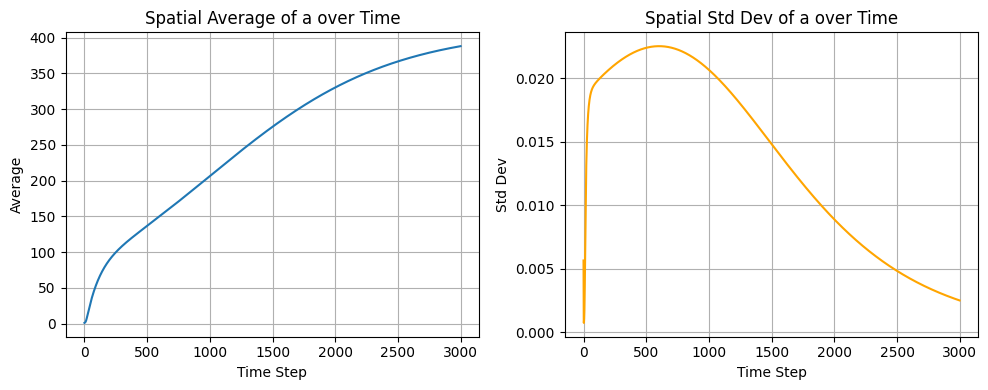

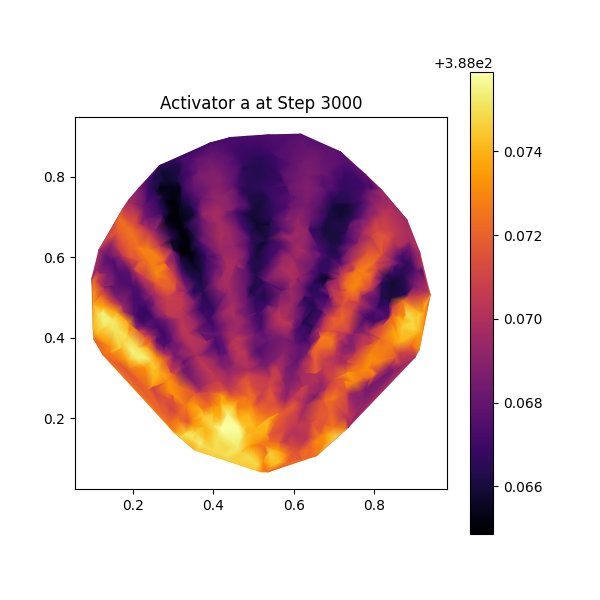

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.spatial import Delaunay

import cv2

# Load and process shell mask image
image_path = 'shell_mask.png'
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
shell_mask = mask // 255

# Normalize dimensions
h, w = shell_mask.shape
x_min, x_max = 0.0, 1.0
y_min, y_max = 0.0, 1.0

# Generate points inside shell mask
num_points = 3000
np.random.seed(0)
rand_pts = np.random.rand(num_points, 2)
rand_pts[:, 0] = rand_pts[:, 0] * (x_max - x_min) + x_min
rand_pts[:, 1] = rand_pts[:, 1] * (y_max - y_min) + y_min

indices_x = np.clip((rand_pts[:, 0] * w).astype(int), 0, w - 1)
indices_y = np.clip(((1 - rand_pts[:, 1]) * h).astype(int), 0, h - 1)
inside_mask = shell_mask[indices_y, indices_x] > 0
points = rand_pts[inside_mask]

tri = Delaunay(points)
triangles = tri.simplices

# Assemble FEM matrices
def assemble_fem_matrices(points, triangles):
    n = len(points)
    M = lil_matrix((n, n))
    K = lil_matrix((n, n))

    for tri in triangles:
        i, j, k = tri
        p0, p1, p2 = np.array(points[i]), np.array(points[j]), np.array(points[k])
        mat_T = np.array([[p1[0] - p0[0], p2[0] - p0[0]], [p1[1] - p0[1], p2[1] - p0[1]]])
        area = 0.5 * abs(np.linalg.det(mat_T))

        inv_J = np.linalg.inv(mat_T)
        grad_phi_ref = np.array([[-1, -1], [1, 0], [0, 1]])
        grad_phi_phys = grad_phi_ref @ inv_J.T

        for a in range(3):
            for b in range(3):
                K[tri[a], tri[b]] += area * np.dot(grad_phi_phys[a], grad_phi_phys[b])
                M[tri[a], tri[b]] += area / 12 if a != b else area / 6

    return M.tocsr(), K.tocsr()

M, K = assemble_fem_matrices(points, triangles)

def initialize_fowler_extended_ridges(points):
    n = len(points)
    a0, h0 = 1.0, 1.0
    a = np.full(n, a0)
    h = np.full(n, h0)


    bottom_center_x = np.mean(points[:, 0])
    bottom_center_y = np.min(points[:, 1])
    center = np.array([bottom_center_x, bottom_center_y])

    for i, (x, y) in enumerate(points):
        dx, dy = x - center[0], y - center[1]
        angle = np.arctan2(dy, dx)


        vertical_factor = (y - bottom_center_y) / (np.max(points[:, 1]) - bottom_center_y + 1e-6)
        modulation = (1 - vertical_factor)
        perturb = 0.1 * np.cos(20 * angle) * modulation

        a[i] += perturb
        h[i] += perturb

    return a, h

a, h = initialize_fowler_extended_ridges(points)


def fem_fowler_step(a, h, M, K, Da, Dh, rho, eps0, mu, eta, gamma, h0, dt):
    a = np.clip(a, 1e-6, 1e3)
    h = np.clip(h, 1e-6, 1e3)

    a2 = a**2
    activation = (a2 / (1 + rho * a2)) / (h + h0) + eps0 - mu * a
    inhibition = eta * (a2 / (1 + rho * a2)) - gamma * h

    A_a = M + dt * Da * K
    A_h = M + dt * Dh * K
    b_a = M @ a + dt * M @ activation
    b_h = M @ h + dt * M @ inhibition

    a_new = spsolve(A_a, b_a)
    h_new = spsolve(A_h, b_h)
    return a_new, h_new


Da = 0.015
Dh = 0.0
rho = 0.1
eps0 = 0.0001
mu = 0.1
eta = 0.0002
gamma = 0.014
h0 = 0.1
dt = 0.1
T = 3000


import matplotlib.tri as mtri
from IPython.display import display
import PIL.Image


from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

snapshots = []
avg_a = []
std_a = []

for t in range(T + 1):
    if t % 500 == 0:
        fig, ax = plt.subplots(figsize=(6, 6))
        FigureCanvas(fig)

        triang = mtri.Triangulation(points[:, 0], points[:, 1], triangles)
        im = ax.tripcolor(triang, a, shading='gouraud', cmap='inferno')
        ax.set_aspect('equal')
        ax.set_title(f"Activator a at Step {t}")
        plt.colorbar(im, ax=ax)

        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.renderer.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        snapshots.append(PIL.Image.fromarray(image[:, :, :3]))
        plt.close(fig)
        plt.savefig(f"second_step_{t}.png")

    if t < T:
        a, h = fem_fowler_step(a, h, M, K, Da, Dh, rho, eps0, mu, eta, gamma, h0, dt)
        avg_a.append(np.mean(a))
        std_a.append(np.std(a))




timesteps = np.arange(0, T)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(timesteps, avg_a, label='Spatial Average of a')
plt.xlabel('Time Step')
plt.ylabel('Average')
plt.title('Spatial Average of a over Time')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(timesteps, std_a, label='Spatial Std Dev of a', color='orange')
plt.xlabel('Time Step')
plt.ylabel('Std Dev')
plt.title('Spatial Std Dev of a over Time')
plt.grid(True)

plt.tight_layout()
plt.show()

snapshots[-1]

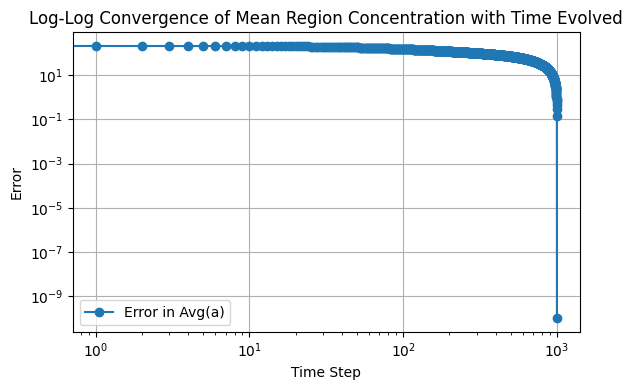

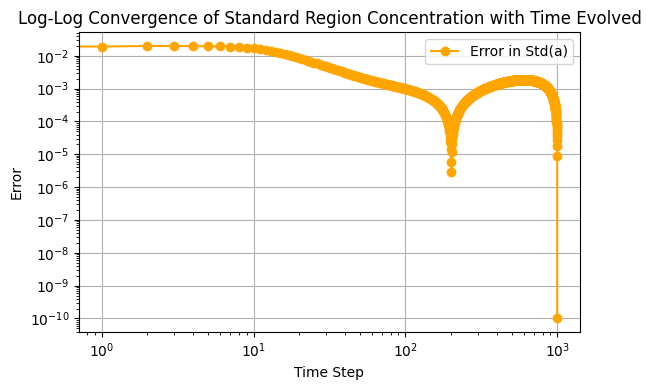

In [20]:
import numpy as np
import matplotlib.pyplot as plt


T_ref_index = 1000
avg_ref = avg_a[T_ref_index]
std_ref = std_a[T_ref_index]

# Create time step array
time_steps = np.arange(0, T_ref_index + 1)

# Compute absolute errors at each step compared to final solution
errors_avg = np.abs(np.array(avg_a[:T_ref_index + 1]) - avg_ref)
errors_std = np.abs(np.array(std_a[:T_ref_index + 1]) - std_ref)

errors_avg = np.clip(errors_avg, 1e-10, None)
errors_std = np.clip(errors_std, 1e-10, None)

# Plot log-log convergence
import matplotlib.pyplot as plt

# First plot: Avg(a)
plt.figure(figsize=(6, 4))
plt.loglog(time_steps, errors_avg, label='Error in Avg(a)', marker='o')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.title('Log-Log Convergence of Mean Region Concentration with Time Evolved')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Second plot: Std(a)
plt.figure(figsize=(6, 4))
plt.loglog(time_steps, errors_std, label='Error in Std(a)', marker='o', color='orange')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.title('Log-Log Convergence of Standard Region Concentration with Time Evolved')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

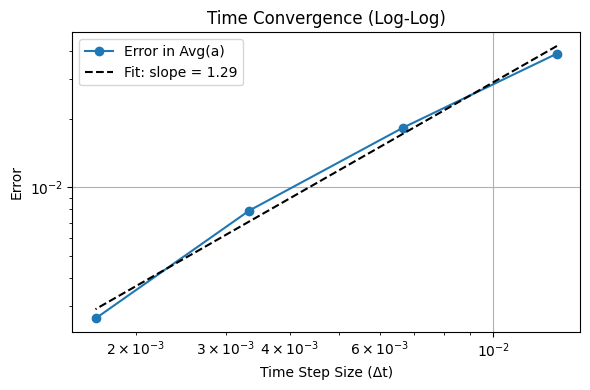

In [21]:
import numpy as np
import matplotlib.pyplot as plt

time_steps_list = [75, 150, 300, 600, 1200]
final_avg_values = []

for num_steps in time_steps_list:
    dt = 1.0 / num_steps
    a, h = initialize_fowler_extended_ridges(points)
    for t in range(num_steps):
        a, h = fem_fowler_step(a, h, M, K, Da, Dh, rho, eps0, mu, eta, gamma, h0, dt)
    final_avg_values.append(np.mean(a))

# Use finest time step as reference
ref_value = final_avg_values[-1]
errors = [abs(val - ref_value) for val in final_avg_values[:-1]]

# Compute dt list
dt_list = [1.0 / n for n in time_steps_list[:-1]]

# Log-log data
log_dt = np.log(dt_list)
log_err = np.log(errors)

slope, intercept = np.polyfit(log_dt, log_err, 1)
fit_line = np.exp(intercept) * np.array(dt_list)**slope

# Plot
plt.figure(figsize=(6, 4))
plt.loglog(dt_list, errors, 'o-', label='Error in Avg(a)')
plt.loglog(dt_list, fit_line, 'k--', label=f'Fit: slope = {slope:.2f}')
plt.xlabel('Time Step Size (Δt)')
plt.ylabel('Error')
plt.title('Time Convergence (Log-Log)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
def fixed_point_iteration(mu2, eta, sigma, rho, rho0, kappa, h0, u0=0.1, tol=1e-10, max_iter=1000):
    u = u0
    for i in range(max_iter):
        v = (sigma + rho * u**2 / (1 + kappa * u**2)) / eta
        u_next = (mu2 / rho) * (v + h0) * (1 + kappa * u**2 + rho0)

        if abs(u_next - u) < tol:
            return u_next, i
        u = u_next
    raise RuntimeError("Fixed-point iteration did not converge")

# Parameters
mu2 = 1e-6
eta = 0.0002
sigma = 0.0001
rho = 0.1
rho0 = 0.1
kappa = 1.0
h0 = 0.1

u_star, num_iters = fixed_point_iteration(mu2, eta, sigma, rho, rho0, kappa, h0)
v_star = (sigma + rho * u_star**2 / (1 + kappa * u_star**2)) / eta

u_star, v_star, num_iters


(6.600000239842878e-06, 0.5000000217800016, 2)

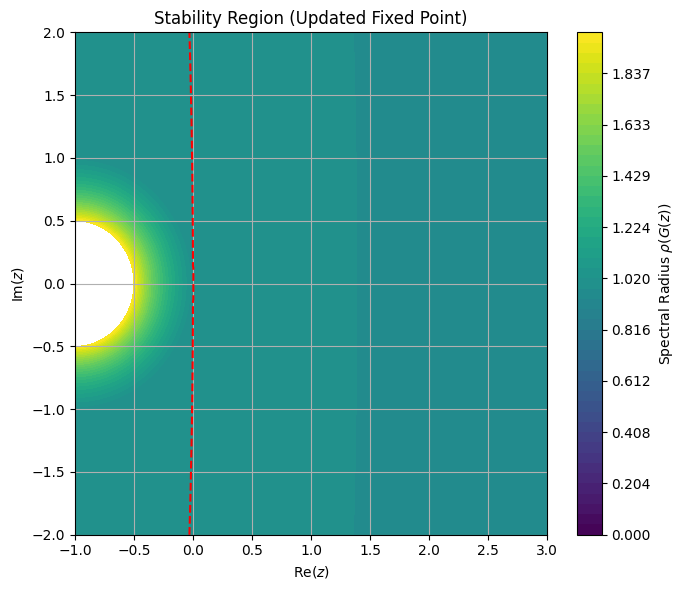

In [23]:
from numpy.linalg import eigvals
# Using the newly computed fixed point
u_star = 6.600000239842878e-06
v_star = 0.5000000217800016

# Update parameters
mu2 = 1e-6
eta = 0.0002
sigma = 0.0001
rho = 0.1
rho0 = 0.1
kappa = 1.0
h0 = 0.1
dt = 0.1


B = 1 + kappa * u_star**2
a = mu2 * ((2 * (1 + rho)) / B - 1)
b = -mu2 * u_star / (v_star + h0)
c = (2 * rho * u_star) / (1 + kappa * u_star**2)**2
d = -eta

# Define matrices
J = np.array([[a, b],
              [c, d]])
D = np.diag([0.015, 1.0])

x_vals = np.linspace(-1, 3, 300)
y_vals = np.linspace(-2, 2, 300)
X, Y = np.meshgrid(x_vals, y_vals)
Z = X + 1j * Y


rho_grid = np.zeros_like(X)

for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        z = Z[i, j]
        try:
            G = np.linalg.inv(np.eye(2) + z * D) @ (np.eye(2) + dt * J)
            eigs = eigvals(G)
            rho_grid[i, j] = max(abs(eigs))
        except np.linalg.LinAlgError:
            rho_grid[i, j] = np.inf

# Plot the stability region in the complex plane
levels = np.linspace(0, 2, 50)
plt.figure(figsize=(7, 6))
contourf = plt.contourf(X, Y, rho_grid, levels=levels, cmap='viridis')
plt.contour(X, Y, rho_grid, levels=[1], colors='red', linewidths=1.5, linestyles='--')

cbar = plt.colorbar(contourf)
cbar.set_label('Spectral Radius $\\rho(G(z))$')

plt.xlabel('Re$(z)$')
plt.ylabel('Im$(z)$')
plt.title('Stability Region (Updated Fixed Point)')
plt.grid(True)
plt.tight_layout()
plt.show()


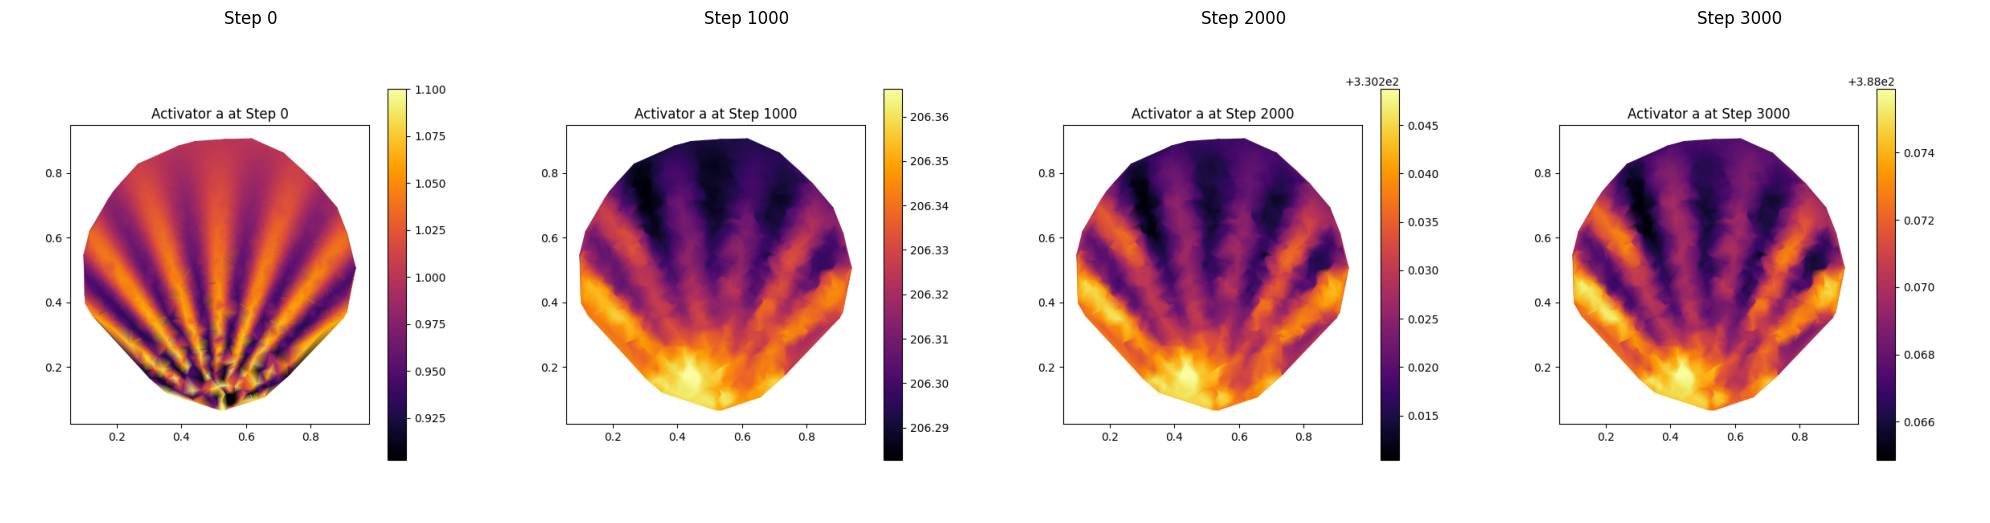

<Figure size 640x480 with 0 Axes>

In [28]:
# Plot snapshots at specific time steps: 0, 1000, 2000, 3000
selected_steps = [0, 1000, 2000, 3000]
selected_images = []

# Map time steps to snapshots
step_to_index = {t: i for i, t in enumerate(range(0, T + 1, 500))}

for t in selected_steps:
    index = step_to_index[t]
    selected_images.append(snapshots[index])

# Plot in a single row
fig, axs = plt.subplots(1, len(selected_steps), figsize=(20, 6))
for ax, img, step in zip(axs, selected_images, selected_steps):
    ax.imshow(img)
    ax.set_title(f"Step {step}")
    ax.axis("off")
plt.tight_layout()
plt.show()
plt.savefig("snapshots.png")

In [29]:

shell_mask_resized = cv2.resize(shell_mask, (gray_shell.shape[1], gray_shell.shape[0]), interpolation=cv2.INTER_NEAREST)


interior_values = gray_shell * shell_mask_resized
interior_normalized = interior_values / 255.0  # Normalize to [0, 1]


h, w = shell_mask_resized.shape
interior_data = []

for x, y in points:
    ix = np.clip(int(x * w), 0, w - 1)
    iy = np.clip(int((1 - y) * h), 0, h - 1)
    interior_data.append(interior_normalized[iy, ix])

interior_data = np.array(interior_data)


from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(interior_data, a)
r2 = r2_score(interior_data, a)


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

triang = mtri.Triangulation(points[:, 0], points[:, 1], triangles)

im0 = axs[0].tripcolor(triang, a, shading='gouraud', cmap='inferno')
axs[0].set_title("Simulation (Activator a)")
axs[0].set_aspect('equal')
plt.colorbar(im0, ax=axs[0])


im1 = axs[1].tripcolor(triang, interior_data, shading='gouraud', cmap='inferno')
axs[1].set_title("Extracted Shell Image")
axs[1].set_aspect('equal')
plt.colorbar(im1, ax=axs[1])

plt.suptitle(f"Comparison at Step 3000 — MSE: {mse:.4f}, R²: {r2:.4f}")
plt.tight_layout()
plt.show()
plt.savefig("comparison.png")

InvalidParameterError: The 'y_pred' parameter of mean_squared_error must be an array-like. Got 1.199999999904168e-06 instead.

In [3]:

import torch
import torch.nn as nn
import torch.optim as optim

class GM_Params(nn.Module):
    def __init__(self):
        super().__init__()
        self.log_Da = nn.Parameter(torch.log(torch.tensor(0.005)))
        self.log_Dv = nn.Parameter(torch.log(torch.tensor(0.05)))
        self.log_rho = nn.Parameter(torch.log(torch.tensor(1.0)))
        self.log_ku  = nn.Parameter(torch.log(torch.tensor(0.03)))
        self.log_kappa = nn.Parameter(torch.log(torch.tensor(0.01)))
        self.log_mu = nn.Parameter(torch.log(torch.tensor(0.1)))

    def forward(self):
        return {
            'Du': torch.exp(self.log_Da),
            'Dv': torch.exp(self.log_Dv),
            'rho': torch.exp(self.log_rho),
            'ku':  torch.exp(self.log_ku),
            'kappa': torch.exp(self.log_kappa),
            'mu':  torch.exp(self.log_mu)
        }

def fem_gm_forward(u0, v0, M, K, params, dt=0.1, T=3000):
    u, v = u0.clone(), v0.clone()
    eps = 1e-6
    for t in range(T):
        vu2 = v**2
        f_u = params['rho'] * (vu2 - params['ku'] * u)
        f_v = params['rho'] * (vu2 / (u * (1 + params['kappa'] * vu2) + eps) - params['mu'] * v)

        A_u = M + dt * params['Du'] * K
        A_v = M + dt * params['Dv'] * K
        b_u = M @ u + dt * (M @ f_u)
        b_v = M @ v + dt * (M @ f_v)

        u = torch.linalg.solve(A_u, b_u)
        v = torch.linalg.solve(A_v, b_v)
    return u

def train_fem_pinn(a0, b0, M, K, real_img, num_epochs=200):
    model = GM_Params()
    optimizer = optim.Adam(model.parameters(), lr=1e-2)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        params = model()
        u_pred = fem_gm_forward(a0, b0, M, K, params, dt=0.1, T=3000)
        loss = torch.mean((u_pred - real_img)**2)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
            print({k: v.item() for k, v in params.items()})
    return model


In [10]:


import torch
import numpy as np
import cv2


a0_np, h0_np = initialize_fowler_extended_ridges(points)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
a0_torch = torch.tensor(a0_np, dtype=torch.float32, device=device)
h0_torch = torch.tensor(h0_np, dtype=torch.float32, device=device)


M_torch = torch.tensor(M.toarray(), dtype=torch.float32, device=device)
K_torch = torch.tensor(K.toarray(), dtype=torch.float32, device=device)

shell_mask_resized = cv2.resize(shell_mask, (gray_shell.shape[1], gray_shell.shape[0]), interpolation=cv2.INTER_NEAREST)
interior_values = gray_shell * shell_mask_resized
interior_normalized = interior_values / 255.0

h_img, w_img = shell_mask_resized.shape
interior_data = []

for x, y in points:
    ix = np.clip(int(x * w_img), 0, w_img - 1)
    iy = np.clip(int((1 - y) * h_img), 0, h_img - 1)
    interior_data.append(interior_normalized[iy, ix])

interior_target = torch.tensor(interior_data, dtype=torch.float32, device=device)

a0_torch.shape, h0_torch.shape, M_torch.shape, interior_target.shape


(torch.Size([1575]),
 torch.Size([1575]),
 torch.Size([1575, 1575]),
 torch.Size([1575]))

Epoch 0, Loss: 6.679667
{'Du': 0.004999999888241291, 'Dv': 0.04999999701976776, 'rho': 1.0, 'ku': 0.029999999329447746, 'kappa': 0.009999999776482582, 'mu': 0.09999999403953552}
Epoch 10, Loss: 4.900687
{'Du': 0.005462337750941515, 'Dv': 0.05094773694872856, 'rho': 0.9061698317527771, 'ku': 0.033138345927000046, 'kappa': 0.011034367606043816, 'mu': 0.11036751419305801}
Epoch 20, Loss: 3.747875
{'Du': 0.005827171262353659, 'Dv': 0.04816829040646553, 'rho': 0.8271181583404541, 'ku': 0.03651142120361328, 'kappa': 0.012082316912710667, 'mu': 0.12099847197532654}
Epoch 30, Loss: 3.002102
{'Du': 0.006025002337992191, 'Dv': 0.0458536297082901, 'rho': 0.7631855607032776, 'ku': 0.04007042199373245, 'kappa': 0.013079626485705376, 'mu': 0.13133057951927185}
Epoch 40, Loss: 2.505212
{'Du': 0.006040559615939856, 'Dv': 0.04373319074511528, 'rho': 0.7120556831359863, 'ku': 0.04380044341087341, 'kappa': 0.013996051624417305, 'mu': 0.1410827338695526}
Epoch 50, Loss: 2.158850
{'Du': 0.00579157238826155

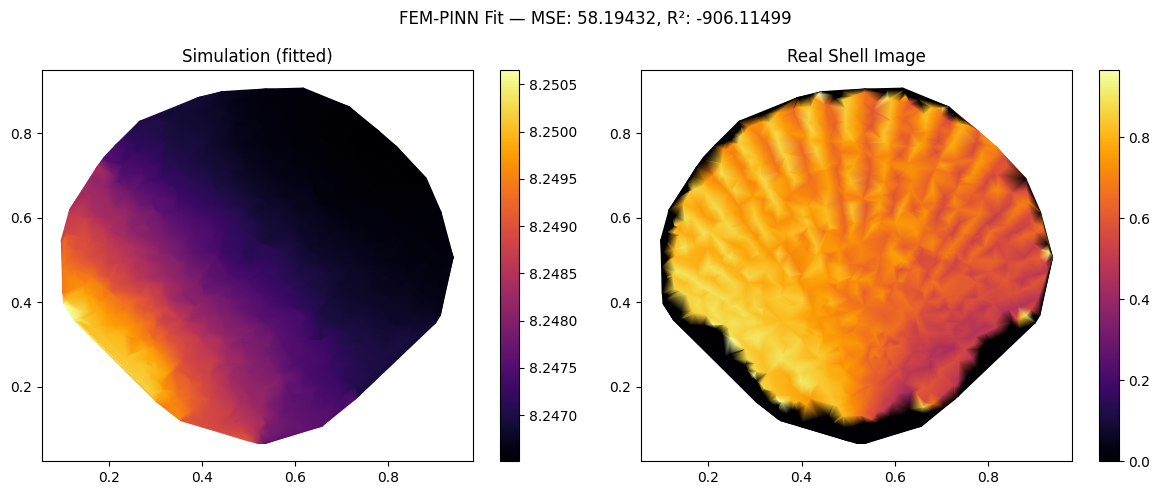

<Figure size 640x480 with 0 Axes>

In [11]:
def train_fem_pinn(a0, b0, M, K, real_img, num_epochs=200):
    class GM_Params(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.log_Da = torch.nn.Parameter(torch.log(torch.tensor(0.005)))
            self.log_Dv = torch.nn.Parameter(torch.log(torch.tensor(0.05)))
            self.log_rho = torch.nn.Parameter(torch.log(torch.tensor(1.0)))
            self.log_ku  = torch.nn.Parameter(torch.log(torch.tensor(0.03)))
            self.log_kappa = torch.nn.Parameter(torch.log(torch.tensor(0.01)))
            self.log_mu = torch.nn.Parameter(torch.log(torch.tensor(0.1)))
        def forward(self):
            return {
                'Du': torch.exp(self.log_Da),
                'Dv': torch.exp(self.log_Dv),
                'rho': torch.exp(self.log_rho),
                'ku':  torch.exp(self.log_ku),
                'kappa': torch.exp(self.log_kappa),
                'mu':  torch.exp(self.log_mu)
            }

    def fem_gm_forward(u0, v0, M, K, params, dt=0.1, T=3000):
        u, v = u0.clone(), v0.clone()
        eps = 1e-6
        for t in range(T):
            vu2 = v**2
            f_u = params['rho'] * (vu2 - params['ku'] * u)
            f_v = params['rho'] * (vu2 / (u * (1 + params['kappa'] * vu2) + eps) - params['mu'] * v)
            A_u = M + dt * params['Du'] * K
            A_v = M + dt * params['Dv'] * K
            b_u = M @ u + dt * (M @ f_u)
            b_v = M @ v + dt * (M @ f_v)
            u = torch.linalg.solve(A_u, b_u)
            v = torch.linalg.solve(A_v, b_v)
        return u

    model = GM_Params()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        params = model()
        u_pred = fem_gm_forward(a0, b0, M, K, params, dt=0.1, T=10)
        loss = torch.mean((u_pred - real_img)**2)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
            print({k: float(v.item()) for k, v in params.items()})
    return model


trained_model = train_fem_pinn(
    a0=a0_torch,
    b0=h0_torch,
    M=M_torch,
    K=K_torch,
    real_img=interior_target,
    num_epochs=300
)

# Simulate final result
final_params = trained_model()
u_final = fem_gm_forward(a0_torch, h0_torch, M_torch, K_torch, final_params, dt=0.1, T=100)
u_final_np = u_final.detach().cpu().numpy()

# Compare to real data
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(interior_data, u_final_np)
r2 = r2_score(interior_data, u_final_np)

# Plot side-by-side
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
triang = mtri.Triangulation(points[:, 0], points[:, 1], triangles)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
im0 = axs[0].tripcolor(triang, u_final_np, shading='gouraud', cmap='inferno')
axs[0].set_title("Simulation (fitted)")
plt.colorbar(im0, ax=axs[0])
im1 = axs[1].tripcolor(triang, interior_data, shading='gouraud', cmap='inferno')
axs[1].set_title("Real Shell Image")
plt.colorbar(im1, ax=axs[1])
plt.suptitle(f"FEM-PINN Fit — MSE: {mse:.5f}, R²: {r2:.5f}")
plt.tight_layout()
plt.show()
plt.savefig("fit_comparison.png")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.spatial import Delaunay
import matplotlib.tri as mtri
import cv2
import PIL.Image
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# Load and process shell mask image
image_path = 'shell_mask.png'
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
shell_mask = mask // 255

# Normalize dimensions
h, w = shell_mask.shape
x_min, x_max = 0.0, 1.0
y_min, y_max = 0.0, 1.0

# Generate points inside shell mask
num_points = 1000
np.random.seed(0)
rand_pts = np.random.rand(num_points, 2)
rand_pts[:, 0] = rand_pts[:, 0] * (x_max - x_min) + x_min
rand_pts[:, 1] = rand_pts[:, 1] * (y_max - y_min) + y_min

indices_x = np.clip((rand_pts[:, 0] * w).astype(int), 0, w - 1)
indices_y = np.clip(((1 - rand_pts[:, 1]) * h).astype(int), 0, h - 1)
inside_mask = shell_mask[indices_y, indices_x] > 0
points = rand_pts[inside_mask]

tri = Delaunay(points)
triangles = tri.simplices

# Assemble FEM matrices
def assemble_fem_matrices(points, triangles):
    n = len(points)
    M = lil_matrix((n, n))
    K = lil_matrix((n, n))

    for tri in triangles:
        i, j, k = tri
        p0, p1, p2 = np.array(points[i]), np.array(points[j]), np.array(points[k])
        mat_T = np.array([[p1[0] - p0[0], p2[0] - p0[0]], [p1[1] - p0[1], p2[1] - p0[1]]])
        area = 0.5 * abs(np.linalg.det(mat_T))

        inv_J = np.linalg.inv(mat_T)
        grad_phi_ref = np.array([[-1, -1], [1, 0], [0, 1]])
        grad_phi_phys = grad_phi_ref @ inv_J.T

        for a in range(3):
            for b in range(3):
                K[tri[a], tri[b]] += area * np.dot(grad_phi_phys[a], grad_phi_phys[b])
                M[tri[a], tri[b]] += area / 12 if a != b else area / 6

    return M.tocsr(), K.tocsr()

M, K = assemble_fem_matrices(points, triangles)

# Initialize activator and inhibitor
def initialize_fowler_extended_ridges(points):
    n = len(points)
    a0, h0 = 1.0, 1.0
    a = np.full(n, a0)
    h = np.full(n, h0)

    bottom_center_x = np.mean(points[:, 0])
    bottom_center_y = np.min(points[:, 1])
    center = np.array([bottom_center_x, bottom_center_y])

    for i, (x, y) in enumerate(points):
        dx, dy = x - center[0], y - center[1]
        angle = np.arctan2(dy, dx)

        vertical_factor = (y - bottom_center_y) / (np.max(points[:, 1]) - bottom_center_y + 1e-6)
        modulation = (1 - vertical_factor)
        perturb = 0.1 * np.cos(20 * angle) * modulation

        a[i] += perturb
        h[i] += perturb

    return a, h

a, h = initialize_fowler_extended_ridges(points)


def fem_fowler_step(a, h, M, K, Da, Dh, rho, eps0, mu, eta, gamma, h0, dt):
    a = np.clip(a, 1e-6, 1e3)
    h = np.clip(h, 1e-6, 1e3)

    a2 = a**2
    activation = (a2 / (1 + rho * a2)) / (h + h0) + eps0 - mu * a
    inhibition = eta * (a2 / (1 + rho * a2)) - gamma * h

    A_a = M + dt * Da * K
    A_h = M + dt * Dh * K
    b_a = M @ a + dt * M @ activation
    b_h = M @ h + dt * M @ inhibition

    a_new = spsolve(A_a, b_a)
    h_new = spsolve(A_h, b_h)
    return a_new, h_new


Da = 0.015
Dh = 0.0
rho = 0.1
eps0 = 0.0001
mu = 1e-6
eta = 0.0002
gamma = 0.014
h0 = 0.1
dt = 0.1
T = 3000

# Steps we want to capture
save_steps = [0, 50, 100, 200, 500, 1000, 2000]

# Main time loop
snapshots = []

for t in range(T + 1):
    if t in save_steps:
        fig, ax = plt.subplots(figsize=(6, 6))
        FigureCanvas(fig)
        triang = mtri.Triangulation(points[:, 0], points[:, 1], triangles)
        im = ax.tripcolor(triang, a, shading='gouraud', cmap='inferno')
        ax.set_aspect('equal')
        ax.set_title(f"Numerical Solution at Step {t}")
        plt.colorbar(im, ax=ax)

        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.renderer.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        image_rgb = image[:, :, :3]
        snapshots.append(PIL.Image.fromarray(image_rgb))
        plt.close(fig)

    if t < T:
        a, h = fem_fowler_step(a, h, M, K, Da, Dh, rho, eps0, mu, eta, gamma, h0, dt)


fig, axes = plt.subplots(1, len(snapshots), figsize=(4 * len(snapshots), 4))

for i, ax in enumerate(axes):
    ax.imshow(snapshots[i])
    ax.set_title(f"Step {save_steps[i]}")
    ax.axis('off')

plt.tight_layout()
plt.savefig("combined_snapshots.png")
plt.show()


<Figure size 640x480 with 0 Axes>

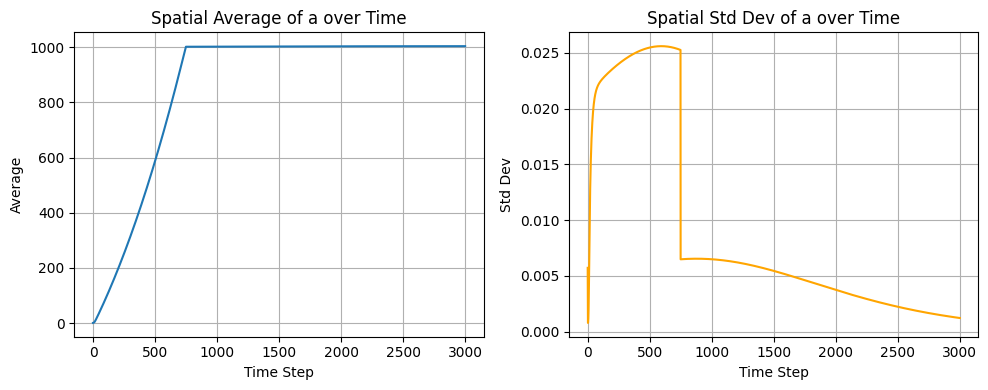

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.spatial import Delaunay

import cv2

# Load and process shell mask image
image_path = 'shell_mask.png'
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
shell_mask = mask // 255

# Normalize dimensions
h, w = shell_mask.shape
x_min, x_max = 0.0, 1.0
y_min, y_max = 0.0, 1.0

num_points = 3000
np.random.seed(0)
rand_pts = np.random.rand(num_points, 2)
rand_pts[:, 0] = rand_pts[:, 0] * (x_max - x_min) + x_min
rand_pts[:, 1] = rand_pts[:, 1] * (y_max - y_min) + y_min

indices_x = np.clip((rand_pts[:, 0] * w).astype(int), 0, w - 1)
indices_y = np.clip(((1 - rand_pts[:, 1]) * h).astype(int), 0, h - 1)
inside_mask = shell_mask[indices_y, indices_x] > 0
points = rand_pts[inside_mask]

tri = Delaunay(points)
triangles = tri.simplices

# Assemble FEM matrices
def assemble_fem_matrices(points, triangles):
    n = len(points)
    M = lil_matrix((n, n))
    K = lil_matrix((n, n))

    for tri in triangles:
        i, j, k = tri
        p0, p1, p2 = np.array(points[i]), np.array(points[j]), np.array(points[k])
        mat_T = np.array([[p1[0] - p0[0], p2[0] - p0[0]], [p1[1] - p0[1], p2[1] - p0[1]]])
        area = 0.5 * abs(np.linalg.det(mat_T))

        inv_J = np.linalg.inv(mat_T)
        grad_phi_ref = np.array([[-1, -1], [1, 0], [0, 1]])
        grad_phi_phys = grad_phi_ref @ inv_J.T

        for a in range(3):
            for b in range(3):
                K[tri[a], tri[b]] += area * np.dot(grad_phi_phys[a], grad_phi_phys[b])
                M[tri[a], tri[b]] += area / 12 if a != b else area / 6

    return M.tocsr(), K.tocsr()

M, K = assemble_fem_matrices(points, triangles)

# Initialize activator and inhibitor
def initialize_fowler_extended_ridges(points):
    n = len(points)
    a0, h0 = 1.0, 1.0
    a = np.full(n, a0)
    h = np.full(n, h0)

    # Use bottom-center as origin
    bottom_center_x = np.mean(points[:, 0])
    bottom_center_y = np.min(points[:, 1])
    center = np.array([bottom_center_x, bottom_center_y])

    for i, (x, y) in enumerate(points):
        dx, dy = x - center[0], y - center[1]
        angle = np.arctan2(dy, dx)


        vertical_factor = (y - bottom_center_y) / (np.max(points[:, 1]) - bottom_center_y + 1e-6)
        modulation = (1 - vertical_factor)
        perturb = 0.1 * np.cos(20 * angle) * modulation

        a[i] += perturb
        h[i] += perturb

    return a, h

a, h = initialize_fowler_extended_ridges(points)

# FEM step using Fowler equations
def fem_fowler_step(a, h, M, K, Da, Dh, rho, eps0, mu, eta, gamma, h0, dt):
    a = np.clip(a, 1e-6, 1e3)
    h = np.clip(h, 1e-6, 1e3)

    a2 = a**2
    activation = (a2 / (1 + rho * a2)) / (h + h0) + eps0 - mu * a
    inhibition = eta * (a2 / (1 + rho * a2)) - gamma * h

    A_a = M + dt * Da * K
    A_h = M + dt * Dh * K
    b_a = M @ a + dt * M @ activation
    b_h = M @ h + dt * M @ inhibition

    a_new = spsolve(A_a, b_a)
    h_new = spsolve(A_h, b_h)
    return a_new, h_new

# Parameters from Fowler et al. (1992)
Da = 0.015
Dh = 0.0
rho = 0.1
eps0 = 0.0001
mu = 1e-6
eta = 0.0002
gamma = 0.014
h0 = 0.1
dt = 0.1
T = 3000




import matplotlib.tri as mtri
from IPython.display import display
import PIL.Image

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

snapshots = []
avg_a = []
std_a = []

for t in range(T + 1):
    if t % 500 == 0:
        fig, ax = plt.subplots(figsize=(6, 6))
        FigureCanvas(fig)  # Attach a canvas explicitly

        triang = mtri.Triangulation(points[:, 0], points[:, 1], triangles)
        im = ax.tripcolor(triang, a, shading='gouraud', cmap='inferno')
        ax.set_aspect('equal')
        ax.set_title(f"Activator a at Step {t}")
        plt.colorbar(im, ax=ax)

        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.renderer.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        snapshots.append(PIL.Image.fromarray(image[:, :, :3]))
        plt.close(fig)
        plt.savefig(f"second_step_{t}.png")

    if t < T:
        a, h = fem_fowler_step(a, h, M, K, Da, Dh, rho, eps0, mu, eta, gamma, h0, dt)
        avg_a.append(np.mean(a))
        std_a.append(np.std(a))


snapshots[-1]

timesteps = np.arange(0, T)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(timesteps, avg_a, label='Spatial Average of a')
plt.xlabel('Time Step')
plt.ylabel('Average')
plt.title('Spatial Average of a over Time')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(timesteps, std_a, label='Spatial Std Dev of a', color='orange')
plt.xlabel('Time Step')
plt.ylabel('Std Dev')
plt.title('Spatial Std Dev of a over Time')
plt.grid(True)

plt.tight_layout()
plt.show()


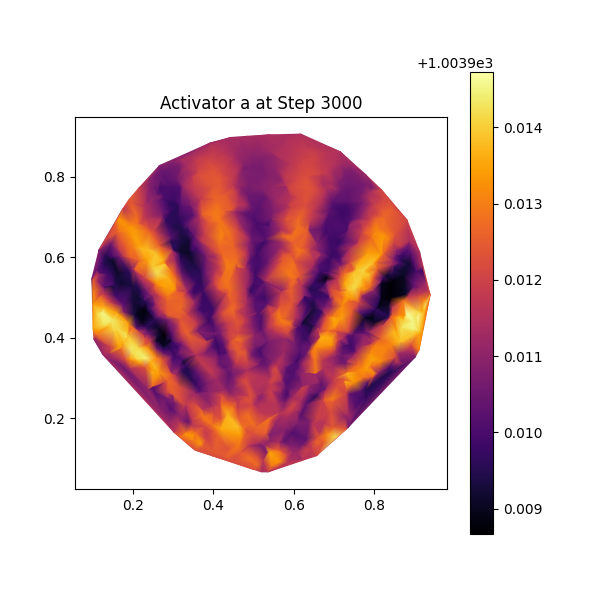

In [34]:

snapshots[-1]

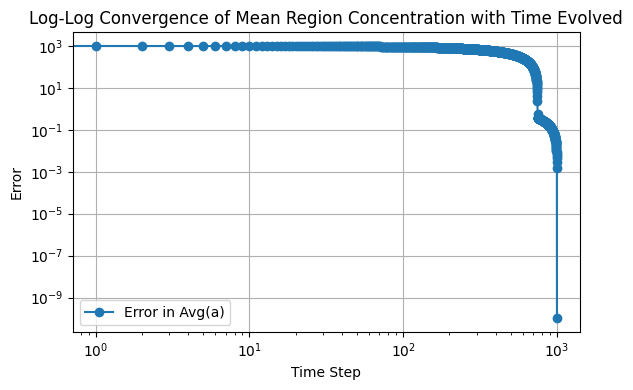

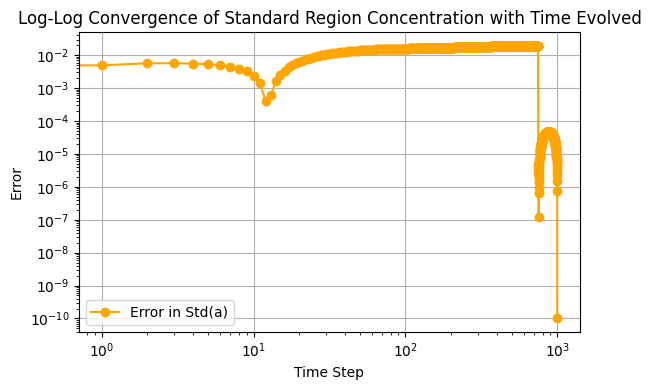

In [35]:
import numpy as np
import matplotlib.pyplot as plt


T_ref_index = 1000
avg_ref = avg_a[T_ref_index]
std_ref = std_a[T_ref_index]

# Create time step array
time_steps = np.arange(0, T_ref_index + 1)

# Compute absolute errors at each step compared to final solution
errors_avg = np.abs(np.array(avg_a[:T_ref_index + 1]) - avg_ref)
errors_std = np.abs(np.array(std_a[:T_ref_index + 1]) - std_ref)

errors_avg = np.clip(errors_avg, 1e-10, None)
errors_std = np.clip(errors_std, 1e-10, None)

# Plot log-log convergence
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 4))
plt.loglog(time_steps, errors_avg, label='Error in Avg(a)', marker='o')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.title('Log-Log Convergence of Mean Region Concentration with Time Evolved')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.loglog(time_steps, errors_std, label='Error in Std(a)', marker='o', color='orange')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.title('Log-Log Convergence of Standard Region Concentration with Time Evolved')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

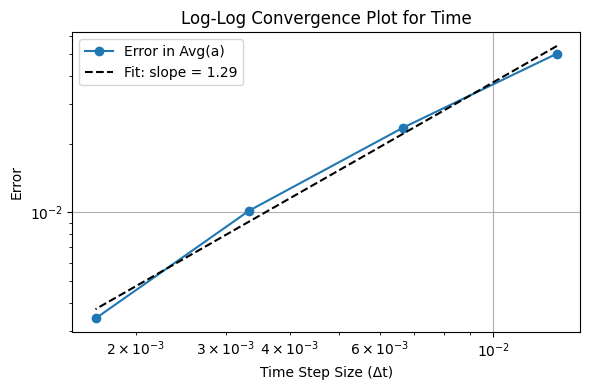

In [36]:
import numpy as np
import matplotlib.pyplot as plt

time_steps_list = [75, 150, 300, 600, 1200]
final_avg_values = []

for num_steps in time_steps_list:
    dt = 1.0 / num_steps
    a, h = initialize_fowler_extended_ridges(points)
    for t in range(num_steps):
        a, h = fem_fowler_step(a, h, M, K, Da, Dh, rho, eps0, mu, eta, gamma, h0, dt)
    final_avg_values.append(np.mean(a))

# Use finest time step as reference
ref_value = final_avg_values[-1]
errors = [abs(val - ref_value) for val in final_avg_values[:-1]]

# Compute dt list
dt_list = [1.0 / n for n in time_steps_list[:-1]]

# Log-log data
log_dt = np.log(dt_list)
log_err = np.log(errors)


slope, intercept = np.polyfit(log_dt, log_err, 1)
fit_line = np.exp(intercept) * np.array(dt_list)**slope

# Plot
plt.figure(figsize=(6, 4))
plt.loglog(dt_list, errors, 'o-', label='Error in Avg(a)')
plt.loglog(dt_list, fit_line, 'k--', label=f'Fit: slope = {slope:.2f}')
plt.xlabel('Time Step Size (Δt)')
plt.ylabel('Error')
plt.title('Log-Log Convergence Plot for Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

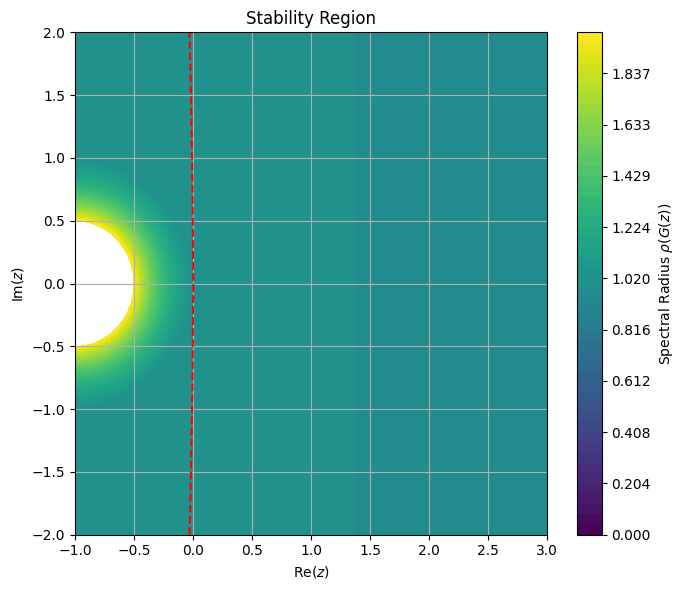

In [37]:
def fixed_point_iteration(mu2, eta, sigma, rho, rho0, kappa, h0, u0=0.1, tol=1e-10, max_iter=1000):
    u = u0
    for i in range(max_iter):
        v = (sigma + rho * u**2 / (1 + kappa * u**2)) / eta
        u_next = (mu2 / rho) * (v + h0) * (1 + kappa * u**2 + rho0)

        if abs(u_next - u) < tol:
            return u_next, i
        u = u_next
    raise RuntimeError("Fixed-point iteration did not converge")

# Parameters
mu2 = 1e-6
eta = 0.0002
sigma = 0.0001
rho = 0.1
rho0 = 0.1
kappa = 1.0
h0 = 0.1


u_star, num_iters = fixed_point_iteration(mu2, eta, sigma, rho, rho0, kappa, h0)
v_star = (sigma + rho * u_star**2 / (1 + kappa * u_star**2)) / eta

u_star, v_star, num_iters

from numpy.linalg import eigvals

u_star = 6.600000239842878e-06
v_star = 0.5000000217800016

# Update parameters
mu2 = 1e-6
eta = 0.0002
sigma = 0.0001
rho = 0.1
rho0 = 0.1
kappa = 1.0
h0 = 0.1
dt = 0.1

B = 1 + kappa * u_star**2
a = mu2 * ((2 * (1 + rho)) / B - 1)
b = -mu2 * u_star / (v_star + h0)
c = (2 * rho * u_star) / (1 + kappa * u_star**2)**2
d = -eta

# Define matrices
J = np.array([[a, b],
              [c, d]])
D = np.diag([0.015, 1.0])


x_vals = np.linspace(-1, 3, 300)
y_vals = np.linspace(-2, 2, 300)
X, Y = np.meshgrid(x_vals, y_vals)
Z = X + 1j * Y


rho_grid = np.zeros_like(X)

for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        z = Z[i, j]
        try:
            G = np.linalg.inv(np.eye(2) + z * D) @ (np.eye(2) + dt * J)
            eigs = eigvals(G)
            rho_grid[i, j] = max(abs(eigs))
        except np.linalg.LinAlgError:
            rho_grid[i, j] = np.inf

# Plot the stability region in the complex plane
levels = np.linspace(0, 2, 50)
plt.figure(figsize=(7, 6))
contourf = plt.contourf(X, Y, rho_grid, levels=levels, cmap='viridis')
plt.contour(X, Y, rho_grid, levels=[1], colors='red', linewidths=1.5, linestyles='--')

cbar = plt.colorbar(contourf)
cbar.set_label('Spectral Radius $\\rho(G(z))$')

plt.xlabel('Re$(z)$')
plt.ylabel('Im$(z)$')
plt.title('Stability Region')
plt.grid(True)
plt.tight_layout()
plt.show()

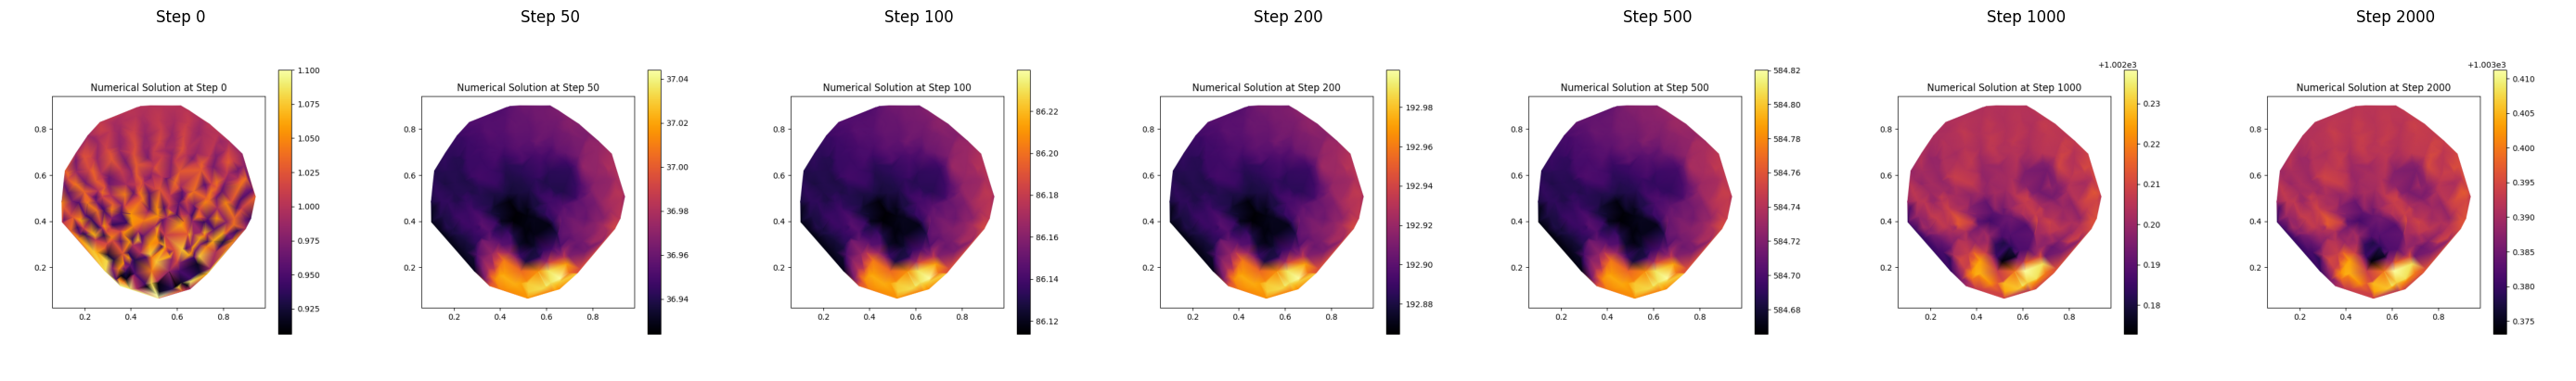

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.spatial import Delaunay
import matplotlib.tri as mtri
import cv2
import PIL.Image
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# Load and process shell mask image
image_path = 'shell_mask.png'
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
shell_mask = mask // 255

# Normalize dimensions
h, w = shell_mask.shape
x_min, x_max = 0.0, 1.0
y_min, y_max = 0.0, 1.0

# Generate points inside shell mask
num_points = 1000
np.random.seed(0)
rand_pts = np.random.rand(num_points, 2)
rand_pts[:, 0] = rand_pts[:, 0] * (x_max - x_min) + x_min
rand_pts[:, 1] = rand_pts[:, 1] * (y_max - y_min) + y_min

indices_x = np.clip((rand_pts[:, 0] * w).astype(int), 0, w - 1)
indices_y = np.clip(((1 - rand_pts[:, 1]) * h).astype(int), 0, h - 1)
inside_mask = shell_mask[indices_y, indices_x] > 0
points = rand_pts[inside_mask]

tri = Delaunay(points)
triangles = tri.simplices

# Assemble FEM matrices
def assemble_fem_matrices(points, triangles):
    n = len(points)
    M = lil_matrix((n, n))
    K = lil_matrix((n, n))

    for tri in triangles:
        i, j, k = tri
        p0, p1, p2 = np.array(points[i]), np.array(points[j]), np.array(points[k])
        mat_T = np.array([[p1[0] - p0[0], p2[0] - p0[0]], [p1[1] - p0[1], p2[1] - p0[1]]])
        area = 0.5 * abs(np.linalg.det(mat_T))

        inv_J = np.linalg.inv(mat_T)
        grad_phi_ref = np.array([[-1, -1], [1, 0], [0, 1]])
        grad_phi_phys = grad_phi_ref @ inv_J.T

        for a in range(3):
            for b in range(3):
                K[tri[a], tri[b]] += area * np.dot(grad_phi_phys[a], grad_phi_phys[b])
                M[tri[a], tri[b]] += area / 12 if a != b else area / 6

    return M.tocsr(), K.tocsr()

M, K = assemble_fem_matrices(points, triangles)

# Initialize activator and inhibitor
def initialize_fowler_extended_ridges(points, num_ridges=18, amplitude=0.1):
    n = len(points)
    a0, h0 = 1.0, 1.0
    a = np.full(n, a0)
    h = np.full(n, h0)

    bottom_center_x = np.mean(points[:, 0])
    bottom_center_y = np.min(points[:, 1])
    center = np.array([bottom_center_x, bottom_center_y])


    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])
    theta_min, theta_max = np.min(angles), np.max(angles)
    angle_range = theta_max - theta_min

    for i, (x, y) in enumerate(points):
        dx, dy = x - center[0], y - center[1]
        theta = np.arctan2(dy, dx)


        theta_normalized = (theta - theta_min) / angle_range

        ridge_pattern = np.cos(2 * np.pi * num_ridges * theta_normalized)

        vertical_factor = (y - bottom_center_y) / (np.max(points[:, 1]) - bottom_center_y + 1e-6)
        modulation = (1 - vertical_factor)

        perturb = amplitude * ridge_pattern * modulation

        a[i] += perturb
        h[i] += perturb

    return a, h



a, h = initialize_fowler_extended_ridges(points)

# FEM update step for Fowler equation
def fem_fowler_step(a, h, M, K, Da, Dh, rho, eps0, mu, eta, gamma, h0, dt):
    a = np.clip(a, 1e-6, 1e3)
    h = np.clip(h, 1e-6, 1e3)

    a2 = a**2
    activation = (a2 / (1 + rho * a2)) / (h + h0) + eps0 - mu * a
    inhibition = eta * (a2 / (1 + rho * a2)) - gamma * h

    A_a = M + dt * Da * K
    A_h = M + dt * Dh * K
    b_a = M @ a + dt * M @ activation
    b_h = M @ h + dt * M @ inhibition

    a_new = spsolve(A_a, b_a)
    h_new = spsolve(A_h, b_h)
    return a_new, h_new

Da = 0.015
Dh = 0.0
rho = 0.1
eps0 = 0.0001
mu = 1e-6
eta = 0.0002
gamma = 0.014
h0 = 0.1
dt = 0.1
T = 3000


save_steps = [0, 50, 100, 200, 500, 1000, 2000]

# Main time loop
snapshots = []

for t in range(T + 1):
    if t in save_steps:
        fig, ax = plt.subplots(figsize=(6, 6))
        FigureCanvas(fig)

        triang = mtri.Triangulation(points[:, 0], points[:, 1], triangles)
        im = ax.tripcolor(triang, a, shading='gouraud', cmap='inferno')
        ax.set_aspect('equal')
        ax.set_title(f"Numerical Solution at Step {t}")
        plt.colorbar(im, ax=ax)

        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.renderer.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        image_rgb = image[:, :, :3]
        snapshots.append(PIL.Image.fromarray(image_rgb))
        plt.close(fig)

    if t < T:
        a, h = fem_fowler_step(a, h, M, K, Da, Dh, rho, eps0, mu, eta, gamma, h0, dt)


fig, axes = plt.subplots(1, len(snapshots), figsize=(4 * len(snapshots), 4))

for i, ax in enumerate(axes):
    ax.imshow(snapshots[i])
    ax.set_title(f"Step {save_steps[i]}")
    ax.axis('off')

plt.tight_layout()
plt.savefig("combined_snapshots.png")
plt.show()


In [39]:
import torch
import numpy as np
import cv2


a0_np, h0_np = initialize_fowler_extended_ridges(points)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
a0_torch = torch.tensor(a0_np, dtype=torch.float32, device=device)
h0_torch = torch.tensor(h0_np, dtype=torch.float32, device=device)

M_torch = torch.tensor(M.toarray(), dtype=torch.float32, device=device)
K_torch = torch.tensor(K.toarray(), dtype=torch.float32, device=device)

shell_mask_resized = cv2.resize(shell_mask, (gray_shell.shape[1], gray_shell.shape[0]), interpolation=cv2.INTER_NEAREST)
interior_values = gray_shell * shell_mask_resized
interior_normalized = interior_values / 255.0
h_img, w_img = shell_mask_resized.shape
interior_data = []

for x, y in points:
    ix = np.clip(int(x * w_img), 0, w_img - 1)
    iy = np.clip(int((1 - y) * h_img), 0, h_img - 1)
    interior_data.append(interior_normalized[iy, ix])

interior_target = torch.tensor(interior_data, dtype=torch.float32, device=device)

a0_torch.shape, h0_torch.shape, M_torch.shape, interior_target.shape


(torch.Size([500]),
 torch.Size([500]),
 torch.Size([500, 500]),
 torch.Size([500]))

In [46]:
def train_fem_pinn(a0, b0, M, K, real_img, num_epochs=200):
    class GM_Params(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.log_Da = torch.nn.Parameter(torch.log(torch.tensor(0.005)))
            self.log_Dv = torch.nn.Parameter(torch.log(torch.tensor(0.05)))
            self.log_rho = torch.nn.Parameter(torch.log(torch.tensor(1.0)))
            self.log_ku  = torch.nn.Parameter(torch.log(torch.tensor(0.03)))
            self.log_kappa = torch.nn.Parameter(torch.log(torch.tensor(0.01)))
            self.log_mu = torch.nn.Parameter(torch.log(torch.tensor(0.001)))
        def forward(self):
            return {
                'Du': torch.exp(self.log_Da),
                'Dv': torch.exp(self.log_Dv),
                'rho': torch.exp(self.log_rho),
                'ku':  torch.exp(self.log_ku),
                'kappa': torch.exp(self.log_kappa),
                'mu':  torch.exp(self.log_mu)
            }

    def fem_gm_forward(u0, v0, M, K, params, dt=0.1, T=3000):
        u, v = u0.clone(), v0.clone()
        eps = 1e-6
        for t in range(T):
            vu2 = v**2
            f_u = params['rho'] * (vu2 - params['ku'] * u)
            f_v = params['rho'] * (vu2 / (u * (1 + params['kappa'] * vu2) + eps) - params['mu'] * v)
            A_u = M + dt * params['Du'] * K
            A_v = M + dt * params['Dv'] * K
            b_u = M @ u + dt * (M @ f_u)
            b_v = M @ v + dt * (M @ f_v)
            u = torch.linalg.solve(A_u, b_u)
            v = torch.linalg.solve(A_v, b_v)
        return u

    model = GM_Params()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        params = model()
        u_pred = fem_gm_forward(a0, b0, M, K, params, dt=0.1, T=200)
        loss = torch.mean((u_pred - real_img)**2)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
            print({k: float(v.item()) for k, v in params.items()})
    return model


trained_model = train_fem_pinn(
    a0=a0_torch,
    b0=h0_torch,
    M=M_torch,
    K=K_torch,
    real_img=interior_target,
    num_epochs=300
)


final_params = trained_model()


Epoch 0, Loss: 5641479.000000
{'Du': 0.004999999888241291, 'Dv': 0.04999999701976776, 'rho': 1.0, 'ku': 0.029999999329447746, 'kappa': 0.009999999776482582, 'mu': 9.999997701015673e-07}


KeyboardInterrupt: 

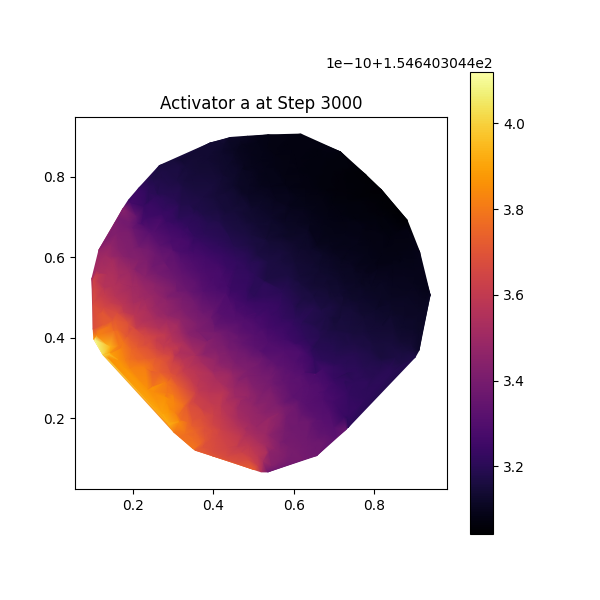

<Figure size 640x480 with 0 Axes>

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.spatial import Delaunay

import cv2

# Load and process shell mask image
image_path = 'shell_mask.png'
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
shell_mask = mask // 255

# Normalize dimensions
h, w = shell_mask.shape
x_min, x_max = 0.0, 1.0
y_min, y_max = 0.0, 1.0

# Generate points inside shell mask
num_points = 3000
np.random.seed(0)
rand_pts = np.random.rand(num_points, 2)
rand_pts[:, 0] = rand_pts[:, 0] * (x_max - x_min) + x_min
rand_pts[:, 1] = rand_pts[:, 1] * (y_max - y_min) + y_min

indices_x = np.clip((rand_pts[:, 0] * w).astype(int), 0, w - 1)
indices_y = np.clip(((1 - rand_pts[:, 1]) * h).astype(int), 0, h - 1)
inside_mask = shell_mask[indices_y, indices_x] > 0
points = rand_pts[inside_mask]

tri = Delaunay(points)
triangles = tri.simplices

# Assemble FEM matrices
def assemble_fem_matrices(points, triangles):
    n = len(points)
    M = lil_matrix((n, n))
    K = lil_matrix((n, n))

    for tri in triangles:
        i, j, k = tri
        p0, p1, p2 = np.array(points[i]), np.array(points[j]), np.array(points[k])
        mat_T = np.array([[p1[0] - p0[0], p2[0] - p0[0]], [p1[1] - p0[1], p2[1] - p0[1]]])
        area = 0.5 * abs(np.linalg.det(mat_T))

        inv_J = np.linalg.inv(mat_T)
        grad_phi_ref = np.array([[-1, -1], [1, 0], [0, 1]])
        grad_phi_phys = grad_phi_ref @ inv_J.T

        for a in range(3):
            for b in range(3):
                K[tri[a], tri[b]] += area * np.dot(grad_phi_phys[a], grad_phi_phys[b])
                M[tri[a], tri[b]] += area / 12 if a != b else area / 6

    return M.tocsr(), K.tocsr()

M, K = assemble_fem_matrices(points, triangles)


def initialize_fowler_extended_ridges(points):
    n = len(points)
    a0, h0 = 1.0, 1.0
    a = np.full(n, a0)
    h = np.full(n, h0)

    # Use bottom-center as origin
    bottom_center_x = np.mean(points[:, 0])
    bottom_center_y = np.min(points[:, 1])
    center = np.array([bottom_center_x, bottom_center_y])

    for i, (x, y) in enumerate(points):
        dx, dy = x - center[0], y - center[1]
        angle = np.arctan2(dy, dx)


        vertical_factor = (y - bottom_center_y) / (np.max(points[:, 1]) - bottom_center_y + 1e-6)
        modulation = (1 - vertical_factor)
        perturb = 0.1 * np.cos(20 * angle) * modulation

        a[i] += perturb
        h[i] += perturb

    return a, h

a, h = initialize_fowler_extended_ridges(points)


def fem_fowler_step(a, h, M, K, Da, Dh, rho, eps0, mu, eta, gamma, h0, dt):
    a = np.clip(a, 1e-6, 1e3)
    h = np.clip(h, 1e-6, 1e3)

    a2 = a**2
    activation = (a2 / (1 + rho * a2)) / (h + h0) + eps0 - mu * a
    inhibition = eta * (a2 / (1 + rho * a2)) - gamma * h

    A_a = M + dt * Da * K
    A_h = M + dt * Dh * K
    b_a = M @ a + dt * M @ activation
    b_h = M @ h + dt * M @ inhibition

    a_new = spsolve(A_a, b_a)
    h_new = spsolve(A_h, b_h)
    return a_new, h_new


Da = final_params['Du'].item()
Dh = final_params['Dv'].item()
rho = final_params['rho'].item()
eps0 = 0.0001
mu = final_params['mu'].item()
eta = final_params['ku'].item()
gamma = final_params['kappa'].item()
h0 = 0.1
dt = 0.1
T = 3000



import matplotlib.tri as mtri
from IPython.display import display
import PIL.Image

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

snapshots = []
avg_a = []
std_a = []

for t in range(T + 1):
    if t % 500 == 0:
        fig, ax = plt.subplots(figsize=(6, 6))
        FigureCanvas(fig)
        triang = mtri.Triangulation(points[:, 0], points[:, 1], triangles)
        im = ax.tripcolor(triang, a, shading='gouraud', cmap='inferno')
        ax.set_aspect('equal')
        ax.set_title(f"Activator a at Step {t}")
        plt.colorbar(im, ax=ax)

        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.renderer.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        snapshots.append(PIL.Image.fromarray(image[:, :, :3]))
        plt.close(fig)
        plt.savefig(f"second_step_{t}.png")

    if t < T:
        a, h = fem_fowler_step(a, h, M, K, Da, Dh, rho, eps0, mu, eta, gamma, h0, dt)
        avg_a.append(np.mean(a))
        std_a.append(np.std(a))


snapshots[-1]